# Imports

In [1]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets
# !pip install -U gensim
# !pip install shap

In [2]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import warnings
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel
from collections import Counter, defaultdict
from gensim.models import Word2Vec
from lime.lime_text import LimeTextExplainer

# Loading Data

In [3]:
df = pd.read_csv('pre-processed data.csv').set_index(['article_id' , 'paragraph_id'], inplace=False)
df['pos_tags'] = df['pos_tags'].apply(ast.literal_eval)
df

text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaran stikstofvergunni...   
           3             hoog drempelwaard vergunning [NEWLINE] aangevo...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergren lang onderwerp discussie huidig Nede...   
...                                                                    ...   
106        2             telgenkamp vestigen hoop kort termijn twee cru...   
107        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
108        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachten patiënt snel zorg helpen [...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group publication_date  \
article_id paragraph_id                                     
1          1             Bouw & Vastgoed       2024-08-28   
           2             Bouw & Vastgoed       2024-08-28   
           3             Bouw & Vastgoed       2024-08-28   
           4             Bouw & Vastgoed       2024-08-28   
           5             Bouw & Vastgoed       2024-08-28   
...                                  ...              ...   
106        2                        Zorg       2024-10-08   
107        1                        Zorg       2024-10-17   
108        1                        Zorg       2024-10-16   
           2                        Zorg       2024-10-16   
           3                        Zorg       2024-10-16   

                                                      file_path  \
article_id paragraph_id                                           
1          1             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           2             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           3             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           4             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           5             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
...                                                         ...   
106        2                        data\Zorg\7, 08-10-2024.pdf   
107        1                        data\Zorg\8, 17-10-2024.pdf   
108        1                        data\Zorg\9, 16-10-2024.pdf   
           2                        data\Zorg\9, 16-10-2024.pdf   
           3                        data\Zorg\9, 16-10-2024.pdf   

                                                             original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
106        2             Telgenkamp vestigt haar hoop voor de korte ter...   
107        1             Waarom verzekeraars inkomsten uit zwart werk w...   
108        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             provincies willen slag versoepeling stikstofre...   
           2             draait allemaal drempelwaarde stikstofvergunni...   
           3             hogere drempelwaarde vergunningen [NE

In [4]:
for group in df['group'].unique():
    print(f"{len(df[df['group'] == group])} paragraphs in {group}.")

106 paragraphs in Bouw & Vastgoed.
101 paragraphs in Handel & Industrie.
71 paragraphs in Zakelijke Dienstverlening.
54 paragraphs in Zorg.


In [5]:
#Try SMOTE and oversampling to balance the data when testing for 2025 data

# Data Splitting

We define a function to split the data over a training-, validation- and test set. <br>
It is important to ensure that all paragraphs of an article must be assigned to the same set to avoid data leakage. <br>
However, since not all articles contain the same number of paragraphs, splitting the data into 3 sets with pre-defined ratios presents a challenge. <br>
To handle this, an incremental solution will be implemented to ensure that we remain close to the pre-defined ratios of the sets.

In [6]:
def split_dataframe_by_articles(df, val_ratio=0.15, test_ratio=0.15, stratify=None, random_seed=53309):

    """
    Splits a multi-index pandas DataFrame (article_id, paragraph_id) into training, validation, and test sets 
    while ensuring that all paragraphs from the same article remain in the same set.

    Parameters:
    - df (pd.DataFrame): DataFrame with the tuple (article_id, paragraph_id) as its multi-index.
    - val_ratio (float): Proportion of data for validation.
    - test_ratio (float): Proportion of data for testing.
    - stratify (str or None): Column name to stratify by at the article level. Defaults to "group" if it exists in df, otherwise None.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - df_train, df_val, df_test (pd.DataFrame): Split DataFrames
    """
    if not (isinstance(val_ratio, float) and isinstance(test_ratio, float)):
        raise ValueError(f"Invalid input types")
    if not (test_ratio + val_ratio < 1.0):
        raise ValueError(f"Invalid input values")
    
    train_ratio = 1.0 - (val_ratio + test_ratio)

    np.random.seed(random_seed)

    # Set default stratify column if not provided
    if stratify is None and "group" in df.columns:
        stratify = "group"

    # Get unique article IDs
    article_ids = df.index.get_level_values(0).unique()

    # If stratify is provided, group article IDs by stratification column
    if stratify and stratify in df.columns:
        stratify_values = df.groupby(level=0)[stratify].first()  # Get the stratify column per article
        stratified_groups = defaultdict(list)
        
        for article_id, value in stratify_values.items():
            stratified_groups[value].append(article_id)
        
        train_ids, val_ids, test_ids = [], [], []

        # Stratify within each group
        for group in stratified_groups.values():
            np.random.shuffle(group)  # Shuffle within the stratification group
            total_articles = len(group)
            
            train_end = round(train_ratio * total_articles)
            val_end = train_end + round(val_ratio * total_articles)

            train_ids.extend(group[:train_end])
            val_ids.extend(group[train_end:val_end])
            test_ids.extend(group[val_end:])
    
    else:
        # Random split without stratification
        shuffled_ids = np.random.permutation(article_ids)

        total_articles = len(shuffled_ids)
        train_end = round(train_ratio * total_articles)
        val_end = train_end + round(val_ratio * total_articles)

        train_ids, val_ids, test_ids = (
            shuffled_ids[:train_end], 
            shuffled_ids[train_end:val_end], 
            shuffled_ids[val_end:]
        )

    # Assign data to splits
    df_train = df.loc[train_ids]
    df_val = df.loc[val_ids]
    df_test = df.loc[test_ids]

    return df_train, df_val, df_test

In [7]:
test1, test2, test3 = split_dataframe_by_articles(df)
total = len(test1) + len(test2) + len(test3)

print("Lengths & Ratios:")
print(len(test1), len(test2), len(test3))
print(len(test1) / total, len(test2) / total, len(test3) / total)

Lengths & Ratios:
238 52 42
0.7168674698795181 0.1566265060240964 0.12650602409638553


As we can see, we roughly achieve the pre-defined ratios

In [8]:
def check_label_distribution(df_train, df_val, df_test, label_col="group"):
    """
    Prints the percentage distribution of labels in train, validation, and test sets.
    
    Parameters:
    - df_train (pd.DataFrame): Training set
    - df_val (pd.DataFrame): Validation set
    - df_test (pd.DataFrame): Test set
    - label_col (str): Column name representing labels
    """
    def compute_distribution(df, label_col):
        return df[label_col].value_counts(normalize=True) * 100  # Convert to percentage

    print("Label Distribution in Training Set:")
    print(compute_distribution(df_train, label_col))
    print("\nLabel Distribution in Validation Set:")
    print(compute_distribution(df_val, label_col))
    print("\nLabel Distribution in Test Set:")
    print(compute_distribution(df_test, label_col))

check_label_distribution(test1, test2, test3)

Label Distribution in Training Set:
Bouw & Vastgoed              30.672269
Handel & Industrie           28.151261
Zakelijke Dienstverlening    23.529412
Zorg                         17.647059
Name: group, dtype: float64

Label Distribution in Validation Set:
Handel & Industrie           40.384615
Bouw & Vastgoed              34.615385
Zakelijke Dienstverlening    13.461538
Zorg                         11.538462
Name: group, dtype: float64

Label Distribution in Test Set:
Bouw & Vastgoed              35.714286
Handel & Industrie           30.952381
Zakelijke Dienstverlening    19.047619
Zorg                         14.285714
Name: group, dtype: float64


As we can see, the data has been stratified so that the class distribution is roughly equal in the 3 sets.

# Overarching Function

**The function evaluate_model() as described below is an overarching function for finding the model with the highest validation accuracy given the provided parameter values.** <br>

Expected parameter values: <br>
- **df**: Pandas DataFrame containing the following columns:
> **original_text**: Text before any pre-processing steps were taken, $str$ <br>
> **text before lemmatization**: Text just before lemmatization has taken place, $str$ <br>
> **text**: Text after all pre-processing steps have been completed, $str$ <br>
> **pos_tags**: Part-Of-Speech tags, $list$ <br>
> **group**: Target variable, $str$ (Converted to numeric in the evaluate_model function) <br>
- **test_ratio**: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> Note that in the case of hold-out cross-validation (which is performed when $k=1$), test_ratio is also used the ratio of training data that is reserved for validation.
- **k_values**: List of k values for k-fold cross-validation. Default value: [2, 3, 5, 10, 20]
- **model_type**: Selects the type of classifier from amongst the following: ["svm", "naive_bayes", "random_forest"].
> If model_type="naive_bayes", a multinomial naive bayes classifier is trained if $pos=$"none" and embedding $\in$ ["BoW", "tf-idf"]. Otherwise, a Gaussian naive bayes classifier is trained since the resulting word embedding will contain continuous features, which multinomial naive bayes classifiers cannot handle.
- **embedding**: Selects the type of word embedding from amongst the following: ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"].
- **pos**: Selects how POS tags are used from amongst the following: ["none", "one-hot", "ngram"].
- **ngram_size**: Selects the type of ngrams that are used. Must be an integer, no smaller than 2. Set to 2 by default.
> Note that if _pos_$\neq$"ngram", n is not used and the value of ngram_size is irrelevant.
- **print_updates**: If set to True, intermediate and final results will be printed in addition to being returned. Default value: True
- **show_class_accuracy**: If set to True, the accuracies per class are shown for the final classifier. Default: True
- **show_confusion_matrix**: If set to True, the resulting confusion matrix of the final classifier will be shown. Default: True
- **return_data**: If set to True, the function returns not only results and best_model, but also the data used to train, validate and test the model
- **save_first_vectorizer**: If True, return first vectorizer as well. Works only for tf-idf.

**The parameters below are model-specific and their values are only relevant if the corresponding model type is selected.**

- **C_values**: A list containing all values of C to be tested for SVM classifiers. Default value: [0.1, 1, 10]
- **kernel_values**: A list containing all kernel types to be tested for SVM classifiers. Default value: ['linear', 'rbf', 'poly']
- **max_depth_values**: A list containing all maximum depth values to be tested for Random Forest classifiers. Default value: [5, 10, 15, 20, None]
- **alpha_values**: A list containing all $\alpha$ values to be tested for multinomial naive bayes classifiers. Default value: [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
- **fit_prior_values**: A list containing all prior_values values to be tested for Multinomial Naive Bayes classifiers. Default value: [True, False]
- **var_smoothing_values**: A list containing all var_smoothing values to be tested for Gaussian Naive Bayes classifiers. Default value: [$10^{-11}$, $10^{-10}$, $10^{-9}$, $10^{-8}$, $10^{-7}$]

In [9]:
def evaluate_model(df: pd.DataFrame, test_ratio: float = 0.15, k_values: list = [2, 3, 5, 10, 20], 
                   model_type: str = "svm", embedding: str = "tf-idf",
                   pos: str = "none", ngram_size: int = 2, print_updates: bool = True,
                   show_class_accuracy: bool = True, show_confusion_matrix: bool = True, 
                   return_data = False, save_first_vectorizer = False,
                   C_values: list = [0.1, 1, 10], kernel_values: list = ['linear', 'rbf', 'poly'],
                   max_depth_values: list = [5, 10, 15, 20, None],
                   alpha_values: list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values: list = [True, False],
                   var_smoothing_values: list = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7]):
    """
    Function to extract embeddings (TF-IDF or BERTje), perform classification with SVM hyperparameter tuning, and evaluate using k-fold cross-validation.

    For parameters, see the markdown above this cell.

    Returns:
        dict: Dictionary of accuracies for each k and best SVM hyperparameters.
    """
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError(f"Invalid test_ratio. Choose a value in the exclusive interval (0,1)")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if model_type.lower() not in ["svm", "naive_bayes", "random_forest"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'Naive_Bayes', 'Random_Forest'}")
    if embedding.lower() not in ["bow", "tf-idf", "bertje", "mbert", "robbert", "word2vec"]:
        raise ValueError(f'Invalid embedding. Choose from ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]')
    if pos not in ["none", "one-hot", "ngram"]:
        raise ValueError(f'Invalid pos. Choose from ["none", "one-hot", "ngram"]')
    if type(ngram_size) != int or ngram_size < 2:
        raise ValueError(f'Invalid ngram_size. Please ensure that ngram_size is an integer, no smaller than 2')
    if not type(print_updates) == bool:
        raise ValueError(f'Invalid print_updates value. Please ensure this parameter has a boolean value.')
    if not isinstance(show_class_accuracy, bool):
        raise ValueError(f'Invalid show_class_accuracy value. Please ensure this parameter has a boolean value.')
    if not isinstance(show_confusion_matrix, bool):
        raise ValueError(f'Invalid show_confusion_matrix value. Please ensure this parameter has a boolean value.')
    if not isinstance(return_data, bool):
        raise ValueError(f'Invalid return_data value. Please ensure this parameter has a boolean value.')
    if not all(x > 0 for x in C_values):
        raise ValueError(f'Invalid C_values. Please ensure that all entries in C_values lie in the exclusive interval (0, inf)')
    if not all(type(x) == str for x in kernel_values):
        raise ValueError(f'Invalid kernel_values. Please ensure every entry in kernel_values is a string that represents a kernel type')
    if not all((type(x) == int and x > 0) or x == None for x in max_depth_values):
        raise ValueError(f'Invalid max_depth_values. Please ensure every entry in max_depth_values is a positive integer or None for no maximum')
    if not all((type(x) == int or type(x) == float) and (x > 0) for x in alpha_values):
        raise ValueError(f'Invalid alpha_values. Please ensure every entry in alpha_values is numeric and non-negative')
    if not all(type(x) == bool for x in fit_prior_values):
        raise ValueError(f'Invalid fit_prior_values. Please ensure every entry in fit_prior_values is boolean')
    if not all(x >= 0 for x in var_smoothing_values):
        raise ValueError(f'Invalid var_smoothing_values. Please ensure every entry in var_smoothing_values is a non-negative number')

    first_iteration = True

    # Convert labels to numeric format
    df["label"] = df["group"].astype("category").cat.codes 
    df_train, df_val, df_test = split_dataframe_by_articles(df, val_ratio=test_ratio, test_ratio=test_ratio, stratify="label")
    
    # ===========================
    # 1. Extract Features (BoW, TF-IDF, BERTje, mBERT, RobBERT or Word2Vec)
    # ===========================

    if embedding.lower() == "bow":
        if print_updates:
            print("\nUsing Bag of Words (BoW) Embeddings...")
        vectorizer = CountVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        val_embeddings = vectorizer.transform(df_val["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])#.toarray()
    
    elif embedding.lower() == "tf-idf":
        if print_updates:
            print("\nUsing TF-IDF Embeddings...")
        vectorizer = TfidfVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        val_embeddings = vectorizer.transform(df_val["text"])
        test_embeddings = vectorizer.transform(df_test["text"])
        if save_first_vectorizer and first_iteration:
            vectorizer_backup = vectorizer
            first_iteration = False

    elif embedding.lower() in ["bertje", "mbert", "robbert"]:
        if embedding.lower() == "bertje":
            model_name = "GroNLP/bert-base-dutch-cased"
        elif embedding.lower() == "mbert":
            model_name = "bert-base-multilingual-cased"
        elif embedding.lower() == "robbert":
            model_name = "pdelobelle/robbert-v2-dutch-base"

        if print_updates:
            print(f"\nUsing {embedding.upper()} Embeddings ({model_name})...")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()

        def get_word_embedding(text):
            with torch.no_grad():
                tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
                output = model(**tokens)
                embeddings = output.last_hidden_state.mean(dim=1)
            return embeddings.squeeze().numpy()

        if print_updates:
            print(f"\nCreating {embedding} embedding, this may take a few minutes.")
        embeddings = np.array([get_word_embedding(text) for text in df_train["text"]])
        val_embeddings = np.array([get_word_embedding(text) for text in df_val["text"]])
        test_embeddings = np.array([get_word_embedding(text) for text in df_test["text"]])

    elif embedding.lower() == "word2vec":
        if print_updates:
            print("\nUsing Word2Vec Embeddings...")

        sentences = [text.split() for text in df_train["text"]]
        w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

        def get_w2v_embedding(text):
            words = text.split()
            word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

        embeddings = np.array([get_w2v_embedding(text) for text in df_train["text"]])
        val_embeddings = np.array([get_w2v_embedding(text) for text in df_val["text"]])
        test_embeddings = np.array([get_w2v_embedding(text) for text in df_test["text"]])

    else:
        raise ValueError("Invalid embedding type. Choose 'tf-idf' 'BERTje', 'mBERT', 'RobBERT' or 'Word2Vec'.")

    # ===========================
    # 2. Process POS Tags if Needed
    # ===========================

    if pos == "one-hot":
        if print_updates:
            print("\nUsing One-Hot Encoding for POS Tags...")

        def pos_to_features(pos_tags):
            """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
            pos_counts = Counter(tag for _, tag in pos_tags)
            return dict(pos_counts)

        # Convert to list of dictionaries
        pos_features = [pos_to_features(tags) for tags in df_train["pos_tags"]]
        val_pos_features = [pos_to_features(tags) for tags in df_val["pos_tags"]]
        test_pos_features = [pos_to_features(tags) for tags in df_test["pos_tags"]]
    
        # Convert list of dictionaries to Pandas DataFrame (fill missing tags with 0)
        pos_df = pd.DataFrame(pos_features).fillna(0)
        pos_df_val = pd.DataFrame(val_pos_features).fillna(0)
        pos_df_test = pd.DataFrame(test_pos_features).fillna(0)

        # Ensure that pos_df_test and pos_df_test have the same columns
        pos_df_val = pos_df_val.reindex(columns=pos_df.columns, fill_value=0)
        pos_df_test = pos_df_test.reindex(columns=pos_df.columns, fill_value=0)
    
        # Create OneHotEncoder and use it on the pos features
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        pos_features_encoded = encoder.fit_transform(pos_df)
        pos_features_encoded_val = encoder.transform(pos_df_val)
        pos_features_encoded_test = encoder.transform(pos_df_test)
    
        # Scale the POS features
        scaler = StandardScaler()
        pos_features_scaled = scaler.fit_transform(pos_features_encoded)
        pos_features_scaled_val = scaler.transform(pos_features_encoded_val)
        pos_features_scaled_test = scaler.transform(pos_features_encoded_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(val_embeddings, np.ndarray):  
            val_embeddings = csr_matrix(val_embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_features_scaled, csr_matrix):  
            pos_features_scaled = csr_matrix(pos_features_scaled)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_val, csr_matrix):  
            pos_features_scaled_val = csr_matrix(pos_features_scaled_val)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_test, csr_matrix):  
            pos_features_scaled_test = csr_matrix(pos_features_scaled_test)  # Convert dense to sparse

        # Combine embeddings with POS features
        embeddings = hstack([embeddings, pos_features_scaled])
        val_embeddings = hstack([val_embeddings, pos_features_scaled_val])
        test_embeddings = hstack([test_embeddings, pos_features_scaled_test])

    elif pos.lower() == "ngram":
        if print_updates:
            print(f"\nUsing N-gram POS Features (n={ngram_size})...")
        
        # Function to convert POS tags to n-grams
        def pos_to_ngrams(pos_tags, n=2):
            """Convert a list of POS-tag tuples into n-gram strings."""
            pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
            ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
            return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

        # Create POS n-grams
        pos_ngrams = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_train["pos_tags"]])
        pos_ngrams_val = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_val["pos_tags"]])
        pos_ngrams_test = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_test["pos_tags"]])

        # Use TF-IDF to extract n-gram features
        vectorizer = TfidfVectorizer(max_features=1000)  # Use fewer features since it's for POS
        pos_embeddings = vectorizer.fit_transform(pos_ngrams)#.toarray()
        pos_embeddings_val = vectorizer.transform(pos_ngrams_val)
        pos_embeddings_test = vectorizer.transform(pos_ngrams_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(val_embeddings, np.ndarray):  
            val_embeddings = csr_matrix(val_embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_embeddings, csr_matrix):  
            pos_embeddings = csr_matrix(pos_embeddings)  # Convert dense to sparse
        if not isinstance(pos_embeddings_val, csr_matrix):  
            pos_embeddings_val = csr_matrix(pos_embeddings_val)  # Convert dense to sparse
        if not isinstance(pos_embeddings_test, csr_matrix):  
            pos_embeddings_test = csr_matrix(pos_embeddings_test)  # Convert dense to sparse
        
        # Combine embeddings with POS n-grams features
        embeddings = hstack([embeddings, pos_embeddings])
        val_embeddings = hstack([val_embeddings, pos_embeddings_val])
        test_embeddings = hstack([test_embeddings, pos_embeddings_test])

    elif pos != "none":
        raise ValueError("Invalid POS type. Choose 'none', 'one-hot', or 'ngram'.")

    # ===========================
    # 3. Model Evaluation (Holdout or k-Fold) with Hyperparameter Search
    # ===========================

    # Set initial performance metrics such that they can be updated after a better classifier has been found
    # best_k = None
    best_accuracy = 0
    best_params = None
    results = {}
    best_functionwide_accuracy = 0
    best_functionwide_params = None

    # For every value of k, we find the best parameter settings and save them in the results dictionary
    for k in k_values:
        param_results = {}
        # accuracy_scores = []
        # best_model_params = {}

        if k == 1: # Use regular hold-out cross-validation
            X_train, X_val, y_train, y_val = embeddings, val_embeddings, df_train["label"], df_val["label"]
            
            if model_type.lower() == "svm":
                for C in C_values:
                    for kernel in kernel_values:
                        classifier = SVC(kernel=kernel, C=C)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((C, kernel), []).append(accuracy)
            
            elif model_type.lower() == "random_forest":
                for max_depth in max_depth_values:
                    classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                    classifier.fit(X_train, y_train)
                    accuracy = accuracy_score(y_val, classifier.predict(X_val))
                    param_results.setdefault((max_depth), []).append(accuracy)
            
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]: # In this case all features are discrete, so we can use MultinomialNB
                    for alpha in alpha_values:
                        for fit_prior in fit_prior_values:
                            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                else: # In this case, there are continuous features, so we use GaussianNB
                    for var_smoothing in var_smoothing_values:
                        classifier = GaussianNB(var_smoothing=var_smoothing)
                        
                        if isinstance(X_train, np.ndarray):
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        else:
                            classifier.fit(X_train.toarray(), y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            
                        param_results.setdefault((var_smoothing), []).append(accuracy)

            else:
                raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')

            # accuracy_scores.append(best_accuracy)
            
        else:  # Use stratified k-fold cross-validation
            X_val = val_embeddings
            y_val = df_val["label"]
            kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
            # for train_index, val_index in kf.split(embeddings, df_train["label"]):
            for fold, (train_index, val_index) in enumerate(kf.split(embeddings, df_train["label"])):
                X_train = embeddings[train_index]
                y_train = df_train["label"].iloc[train_index].values
                
                best_fold_accuracy = 0
                
                if model_type == "svm":
                    for C in C_values:
                        for kernel in kernel_values:
                            classifier = SVC(kernel=kernel, C=C)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((C, kernel), []).append(accuracy)
                
                elif model_type == "random_forest":
                    for max_depth in max_depth_values:
                        classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((max_depth), []).append(accuracy)
                
                elif model_type == "naive_bayes":
                    if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                        for alpha in alpha_values:
                            for fit_prior in fit_prior_values:
                                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                                param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                    else:
                        for var_smoothing in var_smoothing_values:
                            classifier = GaussianNB(var_smoothing=var_smoothing)
                            if isinstance(X_train, np.ndarray):
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            else:
                                classifier.fit(X_train.toarray(), y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            param_results.setdefault((var_smoothing), []).append(accuracy)
                                
                else:
                    raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')
                
                # accuracy_scores.append(best_fold_accuracy)
        
        # results[k] = {"accuracy": np.mean(accuracy_scores), "best_params": best_model_params}

        # Compute mean accuracy for each hyperparameter set
        mean_accuracies = {params: np.mean(acc_list) for params, acc_list in param_results.items()}
        best_params = max(mean_accuracies, key=mean_accuracies.get)
        best_accuracy = mean_accuracies[best_params]
        results[k] = {"accuracy": best_accuracy, "best_params": best_params}
        
        if print_updates:
            print(f"Best {model_type} Params for k={k}: {results[k]['best_params']}, Mean Validation Accuracy: {results[k]['accuracy']:.4f}")
        
        if print_updates:
            print(f"param_results: {param_results}")
            print(f"mean results: {mean_accuracies}")
            print(f"best validation accuracy for K={k}: {best_accuracy}")
            print(f"best functionwide validation accuracy: {best_functionwide_accuracy}\n")

        # Train final model on full training set if this is the best performance so far
        if best_accuracy > best_functionwide_accuracy:
            best_functionwide_accuracy = best_accuracy
            best_functionwide_params = best_params
            if not isinstance(best_params, tuple):
                best_params = (best_params,)
            if model_type.lower() == "svm":
                best_model = SVC(C=best_params[0], kernel=best_params[1])
            elif model_type.lower() == "random_forest":
                best_model = RandomForestClassifier(max_depth=best_params[0], random_state=42)
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                    best_model = MultinomialNB(alpha=best_params[0], fit_prior=best_params[1])
                else:
                    best_model = GaussianNB(var_smoothing=best_params[0])
                    
            if isinstance(X_train, np.ndarray):
                best_model.fit(X_train, y_train)
            else:
                best_model.fit(X_train.toarray(), y_train)
    
    # Evaluate best model on test set

    y_test = df_test["label"]
    if not isinstance(test_embeddings, np.ndarray):
        y_pred = best_model.predict(test_embeddings.toarray())
    else:
        y_pred = best_model.predict(test_embeddings)
    
    y_true = df_test["label"]
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_true, y_pred)
    test_precision = precision_score(y_true, y_pred, average='weighted')
    test_recall = recall_score(y_true, y_pred, average='weighted')
    test_f1 = f1_score(y_true, y_pred, average='weighted')
        
    if print_updates:
        print(f"\nBest model found: \nModel={model_type}, \nParameter values: {best_params}, \nValidation Accuracy: {best_functionwide_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")
        print(f"Final Test Precision: {test_precision:.4f}")
        print(f"Final Test Recall: {test_recall:.4f}")
        print(f"Final Test F1-Score: {test_f1:.4f}")

    if show_class_accuracy:
            
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
            
        cm = confusion_matrix(y_test, y_pred)
        class_mapping = {0: 'Bouw & Vastgoed', 1: 'Handel & Industrie', 2: 'Zakelijke Dienstverlening', 3: 'Zorg'}
        class_names = [class_mapping[i] for i in np.unique(y_test)]
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

    if not save_first_vectorizer:
        if return_data:
            y_test = df_test["label"]
            return results, best_model, [(X_train, y_train), (X_val, y_val), (test_embeddings, y_test)]
        else:
            return results, best_model

    else:
        if return_data:
            y_test = df_test["label"]
            return results, best_model, [(X_train, y_train), (X_val, y_val), (test_embeddings, y_test)], vectorizer_backup
        else:
            return results, best_model, vectorizer_backup

# Testing:


Using TF-IDF Embeddings...
Best random_forest Params for k=2: 15, Mean Validation Accuracy: 0.5532
param_results: {5: [0.3829787234042553, 0.3404255319148936], 10: [0.5319148936170213, 0.46808510638297873], 15: [0.574468085106383, 0.5319148936170213], 20: [0.574468085106383, 0.5106382978723404], None: [0.6170212765957447, 0.46808510638297873]}
mean results: {5: 0.36170212765957444, 10: 0.5, 15: 0.5531914893617021, 20: 0.5425531914893618, None: 0.5425531914893618}
best validation accuracy for K=2: 0.5531914893617021
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 20, Mean Validation Accuracy: 0.5461
param_results: {5: [0.425531914893617, 0.3829787234042553, 0.3829787234042553], 10: [0.5319148936170213, 0.46808510638297873, 0.48936170212765956], 15: [0.48936170212765956, 0.5531914893617021, 0.5531914893617021], 20: [0.5106382978723404, 0.5531914893617021, 0.574468085106383], None: [0.5106382978723404, 0.6170212765957447, 0.5106382978723404]}
mean results: {5

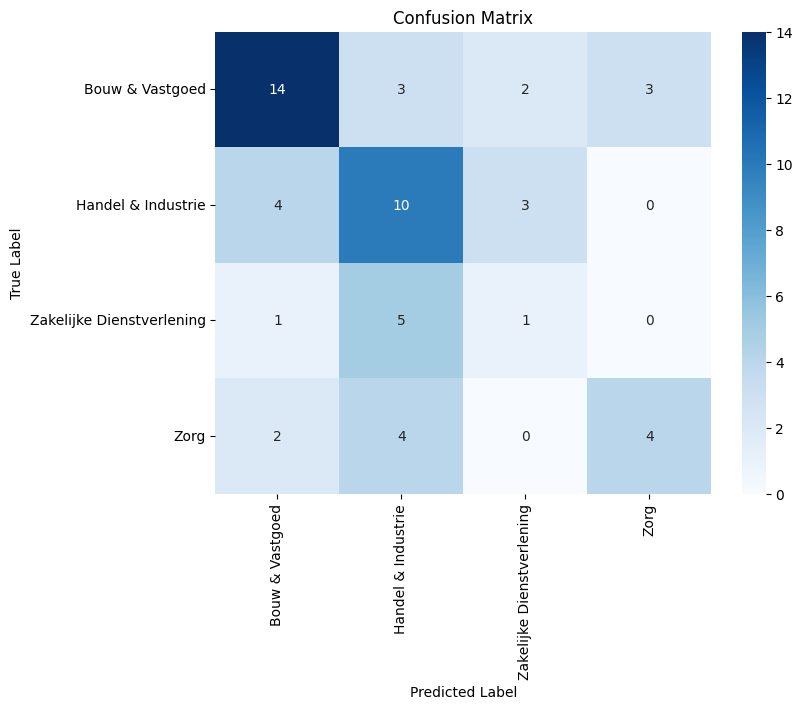

({2: {'accuracy': 0.5531914893617021, 'best_params': 15},
  3: {'accuracy': 0.5460992907801419, 'best_params': 20},
  5: {'accuracy': 0.5659574468085107, 'best_params': None}},
 RandomForestClassifier(random_state=42))

In [123]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2,)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best random_forest Params for k=2: 10, Mean Validation Accuracy: 0.7021
param_results: {5: [0.723404255319149, 0.6170212765957447], 10: [0.7659574468085106, 0.6382978723404256], 15: [0.7659574468085106, 0.6170212765957447], 20: [0.7659574468085106, 0.6170212765957447], None: [0.7659574468085106, 0.6170212765957447]}
mean results: {5: 0.6702127659574468, 10: 0.7021276595744681, 15: 0.6914893617021276, 20: 0.6914893617021276, None: 0.6914893617021276}
best validation accuracy for K=2: 0.7021276595744681
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.7305
param_results: {5: [0.7021276595744681, 0.7446808510638298, 0.7021276595744681], 10: [0.723404255319149, 0.7659574468085106, 0.7021276595744681], 15: [0.7446808510638298, 0.7659574468085106, 0.6808510638297872], 20: [0.7446808510638298, 0.7659574468085106, 0.6808510638297872], None: [0.7446808510638298, 0.765957446808510

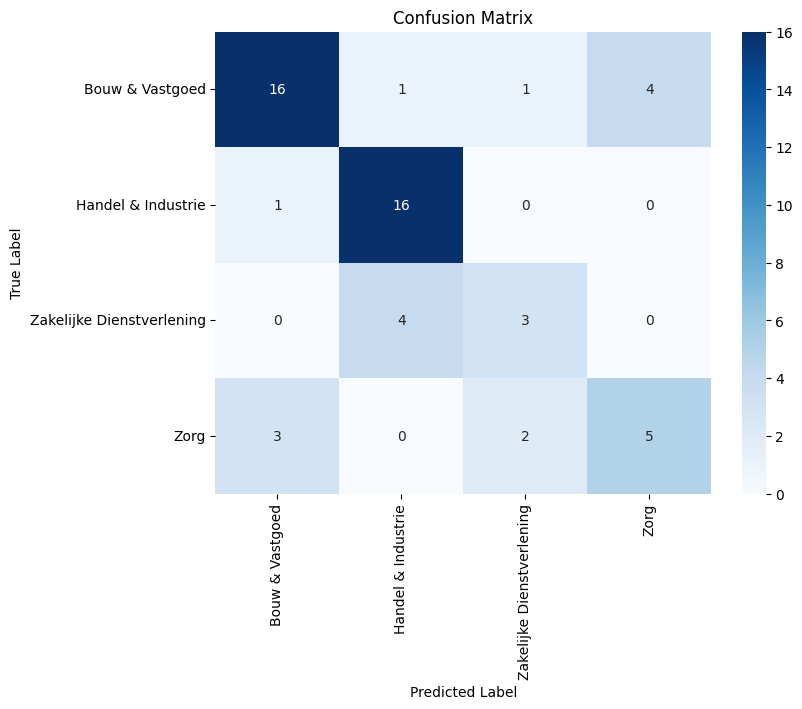

({2: {'accuracy': 0.7021276595744681, 'best_params': 10},
  3: {'accuracy': 0.7304964539007092, 'best_params': 10},
  5: {'accuracy': 0.7319148936170213, 'best_params': 10}},
 RandomForestClassifier(max_depth=10, random_state=42))

In [124]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Using One-Hot Encoding for POS Tags...
Best random_forest Params for k=2: 20, Mean Validation Accuracy: 0.4149
param_results: {5: [0.3617021276595745, 0.40425531914893614], 10: [0.3829787234042553, 0.40425531914893614], 15: [0.3617021276595745, 0.44680851063829785], 20: [0.40425531914893614, 0.425531914893617], None: [0.3829787234042553, 0.44680851063829785]}
mean results: {5: 0.3829787234042553, 10: 0.3936170212765957, 15: 0.4042553191489362, 20: 0.4148936170212766, None: 0.4148936170212766}
best validation accuracy for K=2: 0.4148936170212766
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 20, Mean Validation Accuracy: 0.5674
param_results: {5: [0.3404255319148936, 0.48936170212765956, 0.40425531914893614], 10: [0.44680851063829785, 0.5531914893617021, 0.425531914893617], 15: [0.5319148936170213, 0.574468085106383, 0.48936170212765956], 20: [0.5531914893617021, 0.6382978723404256, 0.5106382978723404], None: [0.5319148936170213

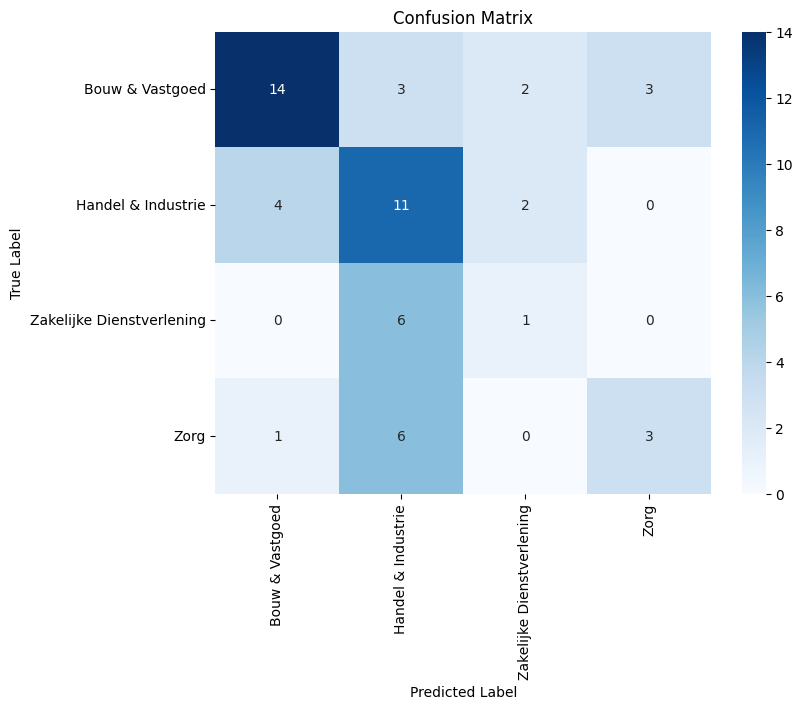

({2: {'accuracy': 0.4148936170212766, 'best_params': 20},
  3: {'accuracy': 0.5673758865248226, 'best_params': 20},
  5: {'accuracy': 0.5319148936170213, 'best_params': 20}},
 RandomForestClassifier(max_depth=20, random_state=42))

In [125]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using MBERT Embeddings (bert-base-multilingual-cased)...

Creating mbert embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best random_forest Params for k=2: 5, Mean Validation Accuracy: 0.6170
param_results: {5: [0.6170212765957447, 0.6170212765957447], 10: [0.574468085106383, 0.6170212765957447], 15: [0.574468085106383, 0.6170212765957447], 20: [0.574468085106383, 0.6170212765957447], None: [0.574468085106383, 0.6170212765957447]}
mean results: {5: 0.6170212765957447, 10: 0.5957446808510638, 15: 0.5957446808510638, 20: 0.5957446808510638, None: 0.5957446808510638}
best validation accuracy for K=2: 0.6170212765957447
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.5957
param_results: {5: [0.5957446808510638, 0.5319148936170213, 0.5957446808510638], 10: [0.6170212765957447, 0.6170212765957447, 0.5531914893617021], 15: [0.6170212765957447, 0.5957446808510638, 0.5531914893617021], 20: [0.6170212765957

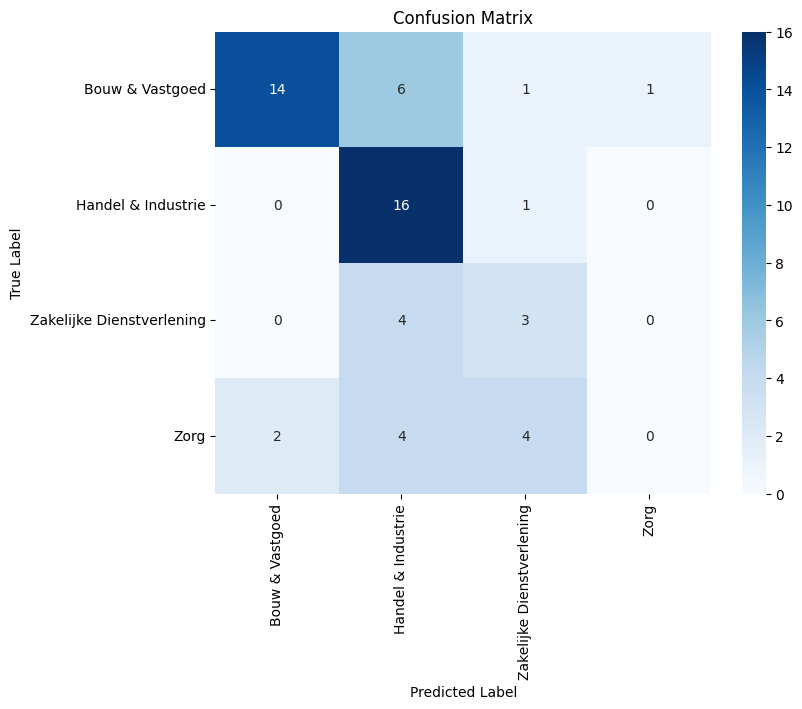

({2: {'accuracy': 0.6170212765957447, 'best_params': 5},
  3: {'accuracy': 0.5957446808510638, 'best_params': 10},
  5: {'accuracy': 0.6297872340425532, 'best_params': 10}},
 RandomForestClassifier(max_depth=10, random_state=42))

In [126]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "mbert", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best svm Params for k=2: (10, 'poly'), Mean Validation Accuracy: 0.8191
param_results: {(0.1, 'linear'): [0.851063829787234, 0.7021276595744681], (0.1, 'rbf'): [0.2127659574468085, 0.2127659574468085], (0.1, 'poly'): [0.2127659574468085, 0.23404255319148937], (1, 'linear'): [0.8297872340425532, 0.7021276595744681], (1, 'rbf'): [0.5319148936170213, 0.5106382978723404], (1, 'poly'): [0.5319148936170213, 0.5319148936170213], (10, 'linear'): [0.8297872340425532, 0.7021276595744681], (10, 'rbf'): [0.8297872340425532, 0.7872340425531915], (10, 'poly'): [0.8723404255319149, 0.7659574468085106]}
mean results: {(0.1, 'linear'): 0.7765957446808511, (0.1, 'rbf'): 0.2127659574468085, (0.1, 'poly'): 0.22340425531914893, (1, 'linear'): 0.7659574468085106, (1, 'rbf'): 0.5212765957446808, (1, 'poly'): 0.5319148936170213, (10, 'linear'): 0.7659574468085106, (10, 'rbf'): 0.8085106382978724, (10, 'poly'): 0.8191489361702128}
best validation accurac

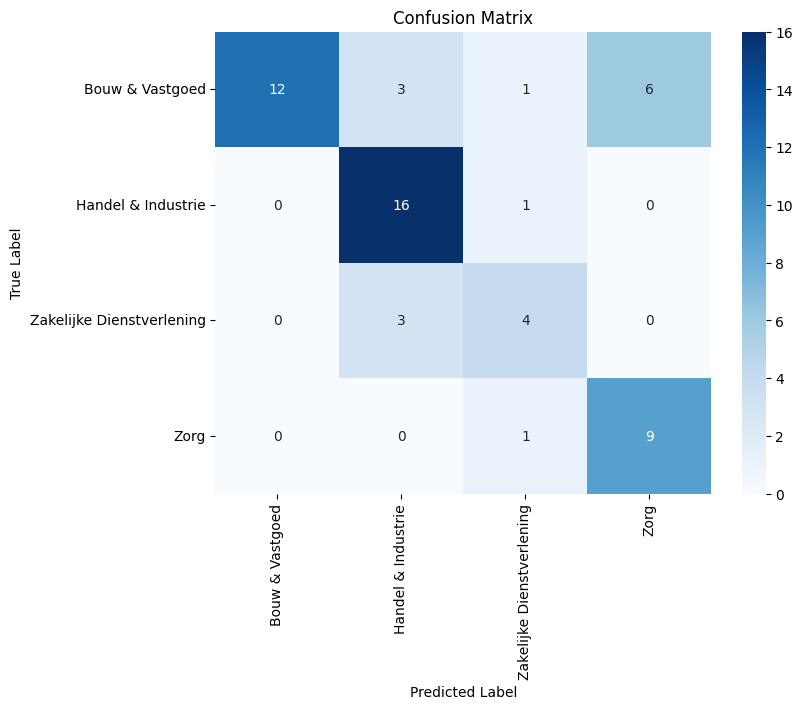

({2: {'accuracy': 0.8191489361702128, 'best_params': (10, 'poly')},
  3: {'accuracy': 0.8439716312056738, 'best_params': (10, 'rbf')},
  5: {'accuracy': 0.8468085106382979, 'best_params': (10, 'rbf')}},
 SVC(C=10))

In [127]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using One-Hot Encoding for POS Tags...
Best svm Params for k=2: (1, 'rbf'), Mean Validation Accuracy: 0.6700
param_results: {(0.1, 'linear'): [0.5, 0.52], (0.1, 'rbf'): [0.36, 0.36], (0.1, 'poly'): [0.36, 0.36], (1, 'linear'): [0.5, 0.52], (1, 'rbf'): [0.68, 0.66], (1, 'poly'): [0.4, 0.46], (10, 'linear'): [0.5, 0.52], (10, 'rbf'): [0.52, 0.56], (10, 'poly'): [0.52, 0.5]}
mean results: {(0.1, 'linear'): 0.51, (0.1, 'rbf'): 0.36, (0.1, 'poly'): 0.36, (1, 'linear'): 0.51, (1, 'rbf'): 0.67, (1, 'poly'): 0.43000000000000005, (10, 'linear'): 0.51, (10, 'rbf'): 0.54, (10, 'poly'): 0.51}
best validation accuracy for K=2: 0.67
best functionwide validation accuracy: 0

Best svm Params for k=3: (1, 'rbf'), Mean Validation Accuracy: 0.6800
param_results: {(0.1, 'linear'): [0.52, 0.5, 0.5], (0.1, 'rbf'): [0.36, 0.36, 0.36], (0.1, 'poly'): [0.36, 0.36, 0.36], (1, 'linear'): [0.52, 0.5, 0.5], (1, 'rbf'): [0.68, 0.66, 0.7], (1, 'poly'): [0.46, 0.44, 0.46], (10

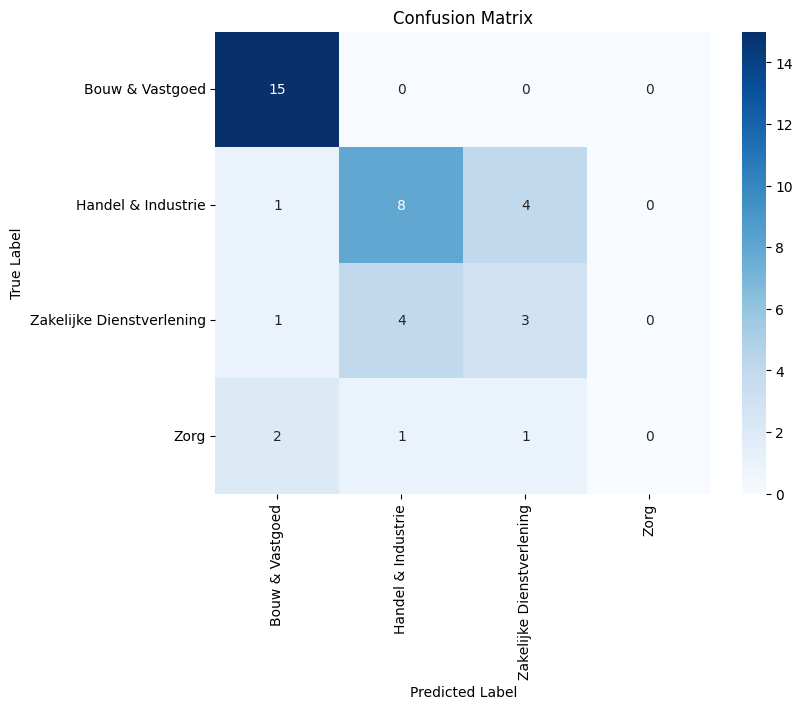

({2: {'accuracy': 0.67, 'best_params': (1, 'rbf')},
  3: {'accuracy': 0.68, 'best_params': (1, 'rbf')},
  5: {'accuracy': 0.6880000000000001, 'best_params': (1, 'rbf')}},
 SVC(C=1))

In [213]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating robBERT embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best svm Params for k=2: (1, 'linear'), Mean Validation Accuracy: 0.9149
param_results: {(0.1, 'linear'): [0.8085106382978723, 0.7021276595744681], (0.1, 'rbf'): [0.2127659574468085, 0.2127659574468085], (0.1, 'poly'): [0.2127659574468085, 0.2127659574468085], (1, 'linear'): [0.8723404255319149, 0.9574468085106383], (1, 'rbf'): [0.48936170212765956, 0.5106382978723404], (1, 'poly'): [0.48936170212765956, 0.5106382978723404], (10, 'linear'): [0.8723404255319149, 0.9361702127659575], (10, 'rbf'): [0.7446808510638298, 0.6170212765957447], (10, 'poly'): [0.723404255319149, 0.6595744680851063]}
mean results: {(0.1, 'linear'): 0.7553191489361701, (0.1, 'rbf'): 0.2127659574468085, (0.1, 'poly'): 0.2127659574468085, (1, 'linear'): 0.9148936170212767, (1, 'rbf'): 0.5, (1, 'poly'): 0.5, (10, 'linear'): 0.9042553191489362, (10, 'rbf'): 0.6808510638297872, (10, 'poly'): 0.6914893617021276}
best validation

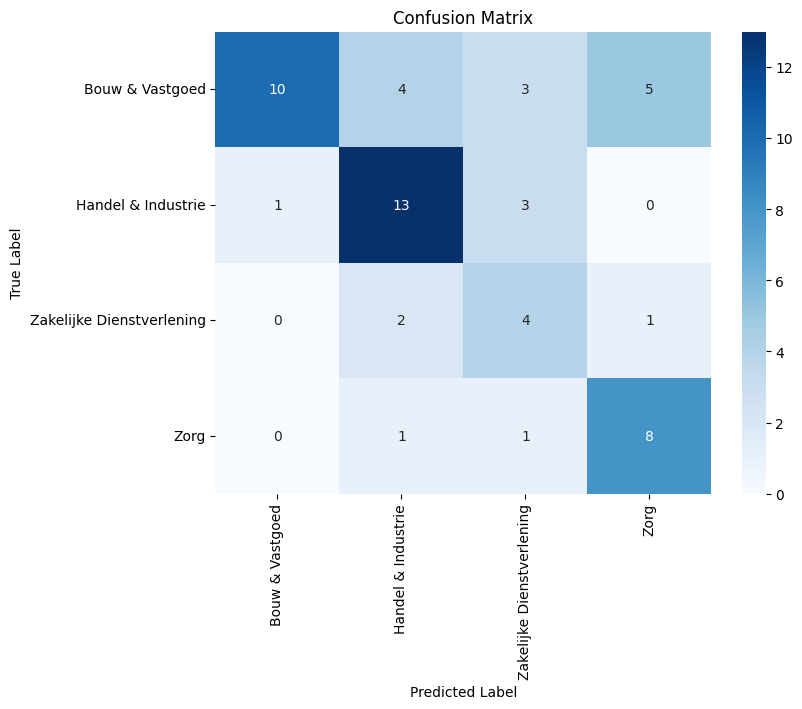

({2: {'accuracy': 0.9148936170212767, 'best_params': (1, 'linear')},
  3: {'accuracy': 0.8368794326241135, 'best_params': (0.1, 'linear')},
  5: {'accuracy': 0.8340425531914895, 'best_params': (10, 'poly')}},
 SVC(C=1, kernel='linear'))

In [129]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "robBERT", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.6170
param_results: {(0.01, True): [0.6382978723404256, 0.5319148936170213], (0.01, False): [0.6382978723404256, 0.5319148936170213], (0.1, True): [0.6595744680851063, 0.5319148936170213], (0.1, False): [0.6595744680851063, 0.574468085106383], (0.5, True): [0.44680851063829785, 0.3404255319148936], (0.5, False): [0.6382978723404256, 0.5319148936170213], (1.0, True): [0.2978723404255319, 0.2553191489361702], (1.0, False): [0.5531914893617021, 0.44680851063829785], (2.0, True): [0.23404255319148937, 0.2127659574468085], (2.0, False): [0.46808510638297873, 0.3191489361702128], (5.0, True): [0.2127659574468085, 0.2127659574468085], (5.0, False): [0.2765957446808511, 0.2553191489361702], (10.0, True): [0.2127659574468085, 0.2127659574468085], (10.0, False): [0.23404255319148937, 0.2553191489361702]}
mean results: {(0.01, True): 0.5851063829787234, (0.01, False): 0.5851063829787234, (0.1, T

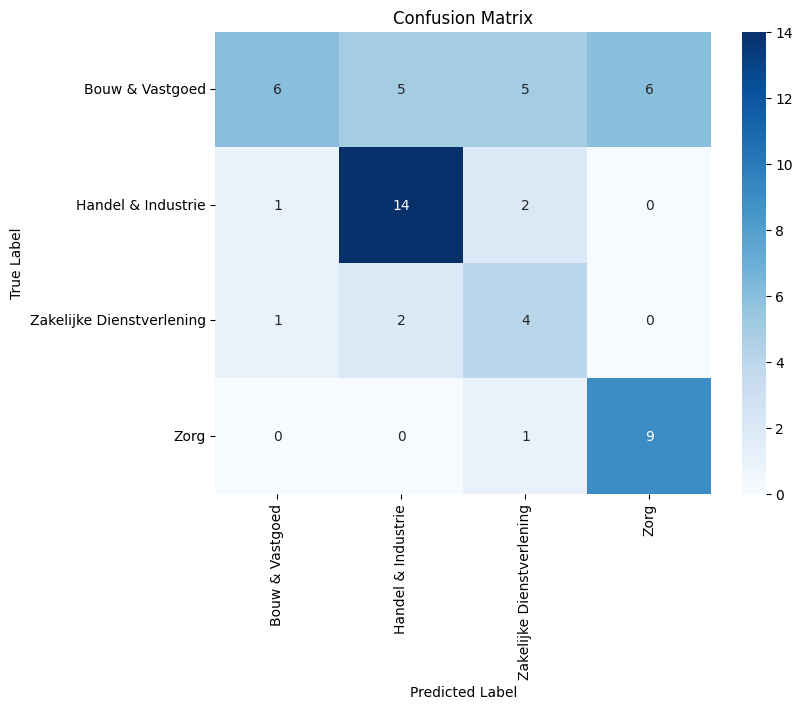

({2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [130]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.6170
param_results: {(0.01, True): [0.6382978723404256, 0.5319148936170213], (0.01, False): [0.6382978723404256, 0.5319148936170213], (0.1, True): [0.6595744680851063, 0.5319148936170213], (0.1, False): [0.6595744680851063, 0.574468085106383], (0.5, True): [0.44680851063829785, 0.3404255319148936], (0.5, False): [0.6382978723404256, 0.5319148936170213], (1.0, True): [0.2978723404255319, 0.2553191489361702], (1.0, False): [0.5531914893617021, 0.44680851063829785], (2.0, True): [0.23404255319148937, 0.2127659574468085], (2.0, False): [0.46808510638297873, 0.3191489361702128], (5.0, True): [0.2127659574468085, 0.2127659574468085], (5.0, False): [0.2765957446808511, 0.2553191489361702], (10.0, True): [0.2127659574468085, 0.2127659574468085], (10.0, False): [0.23404255319148937, 0.2553191489361702]}
mean results: {(0.01, True): 0.5851063829787234, (0.01, False): 0.5851063829787234, (0.1, T

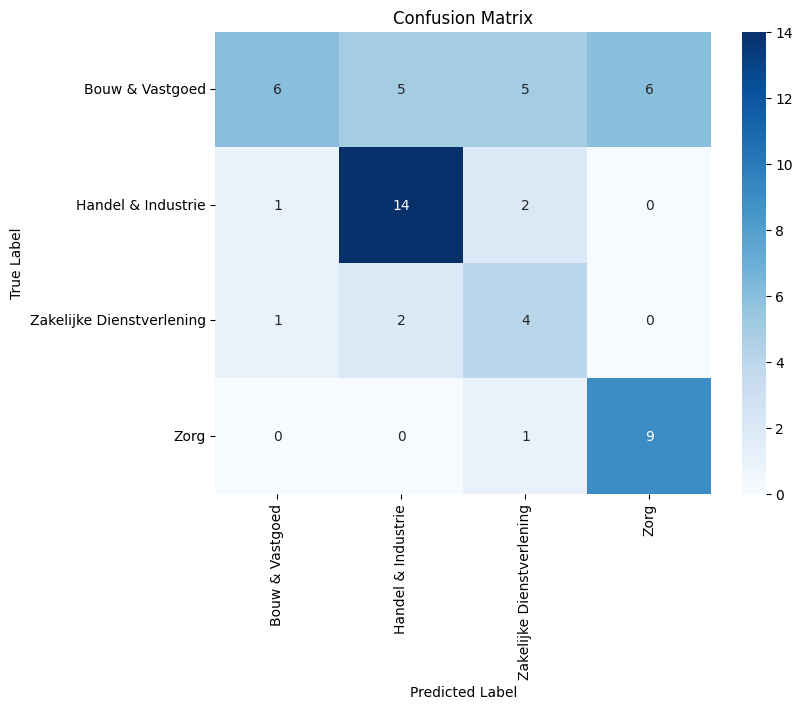

({2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [131]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using N-gram POS Features (n=2)...
Best naive_bayes Params for k=2: 1e-11, Mean Validation Accuracy: 0.5319
param_results: {1e-11: [0.574468085106383, 0.48936170212765956], 1e-10: [0.574468085106383, 0.48936170212765956], 1e-09: [0.574468085106383, 0.48936170212765956], 1e-08: [0.574468085106383, 0.48936170212765956], 1e-07: [0.574468085106383, 0.48936170212765956]}
mean results: {1e-11: 0.5319148936170213, 1e-10: 0.5319148936170213, 1e-09: 0.5319148936170213, 1e-08: 0.5319148936170213, 1e-07: 0.5319148936170213}
best validation accuracy for K=2: 0.5319148936170213
best functionwide validation accuracy: 0

Best naive_bayes Params for k=3: 1e-07, Mean Validation Accuracy: 0.4894
param_results: {1e-11: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-10: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-09: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-08: [0.5106382978723404, 0.4893617021276

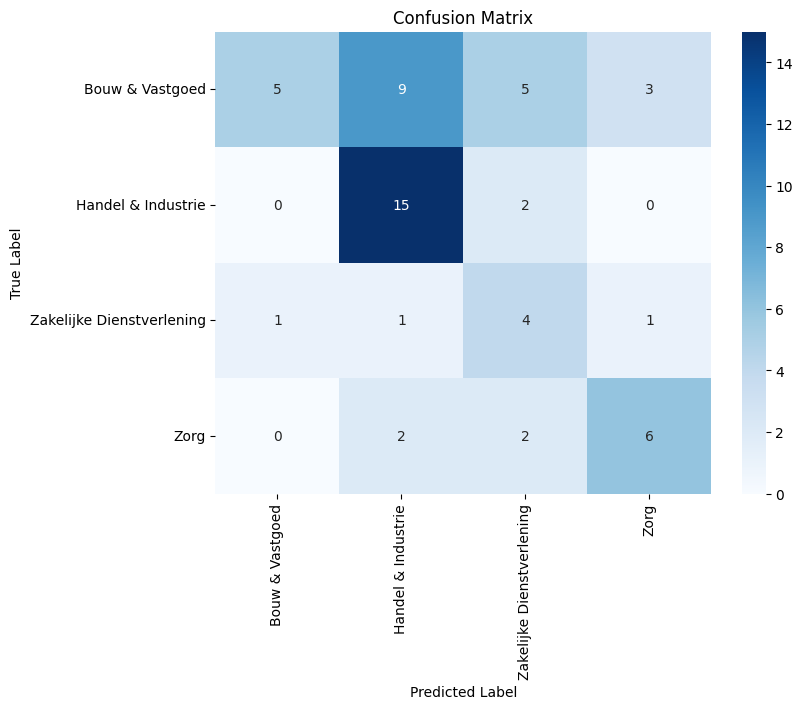

({2: {'accuracy': 0.5319148936170213, 'best_params': 1e-11},
  3: {'accuracy': 0.48936170212765956, 'best_params': 1e-07},
  5: {'accuracy': 0.5148936170212767, 'best_params': 1e-08}},
 GaussianNB(var_smoothing=1e-11))

In [132]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=1: (0.1, False), Mean Validation Accuracy: 0.6383
param_results: {(0.01, True): [0.5957446808510638], (0.01, False): [0.574468085106383], (0.1, True): [0.5531914893617021], (0.1, False): [0.6382978723404256], (0.5, True): [0.46808510638297873], (0.5, False): [0.574468085106383], (1.0, True): [0.3617021276595745], (1.0, False): [0.5319148936170213], (2.0, True): [0.2553191489361702], (2.0, False): [0.46808510638297873], (5.0, True): [0.2127659574468085], (5.0, False): [0.3404255319148936], (10.0, True): [0.2127659574468085], (10.0, False): [0.2553191489361702]}
mean results: {(0.01, True): 0.5957446808510638, (0.01, False): 0.574468085106383, (0.1, True): 0.5531914893617021, (0.1, False): 0.6382978723404256, (0.5, True): 0.46808510638297873, (0.5, False): 0.574468085106383, (1.0, True): 0.3617021276595745, (1.0, False): 0.5319148936170213, (2.0, True): 0.2553191489361702, (2.0, False): 0.46808510638297873, (5.0, True): 0.21276595

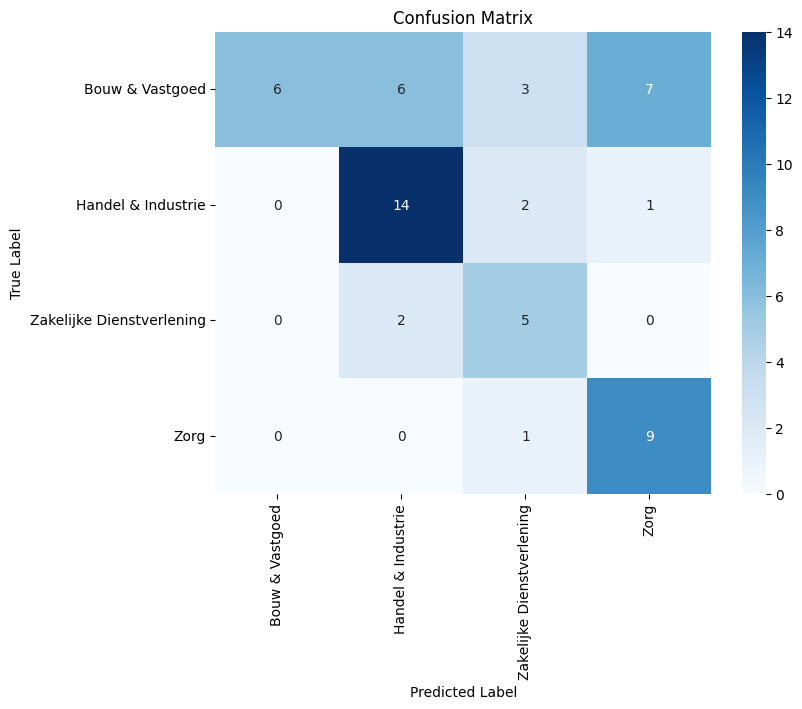

({1: {'accuracy': 0.6382978723404256, 'best_params': (0.1, False)},
  2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)},
  10: {'accuracy': 0.625531914893617, 'best_params': (0.1, False)},
  20: {'accuracy': 0.6297872340425531, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [133]:
evaluate_model(df, test_ratio=0.15, k_values=[1, 2, 3, 5, 10, 20],
               embedding="tf-idf", model_type="naive_bayes", pos="none", 
               ngram_size=2, print_updates=True, show_class_accuracy=True, 
               show_confusion_matrix=True, return_data=False,
               save_first_vectorizer=False)

In [ ]:
# To Do:

# -Add some print statements to show the model chosen en parameters, especially for Gaussian- of Multinomial Naive Bayes
# -Print update of best model after every k
# -Clean Code and add/remove/update comments where needed
# -Return actual model and validation accuracy such that we can visualize the results in confusion matrices
# -If 2 classes too close in likelihood or no class likelihood exceeds threshold, then say class 5

# Finding the best model

Our goal is to find the classifier with the highest validation accuracy for each model type

In [10]:
# Ignore all warnings since they cause problems for te progress bars
warnings.simplefilter("ignore")

In [41]:
# Naive Bayes

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="naive_bayes",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:01<00:38,  1.33s/iteration]

Maximum validation accuracy this iteration: 0.7307692307692307
Best validaton accuracy increased from -inf to 0.7307692307692307 with params BoW, none, (0.1, True).

testing for embedding=BoW, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:   7%|████▍                                                             | 2/30 [00:11<03:01,  6.50s/iteration]

Maximum validation accuracy this iteration: 0.5826923076923076

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [00:21<03:35,  7.99s/iteration]

Maximum validation accuracy this iteration: 0.6538461538461539

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [00:31<03:56,  9.08s/iteration]

Maximum validation accuracy this iteration: 0.6538461538461539

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|███████████                                                       | 5/30 [00:43<04:04,  9.79s/iteration]

Maximum validation accuracy this iteration: 0.6346153846153846

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|█████████████▏                                                    | 6/30 [00:44<02:45,  6.89s/iteration]

Maximum validation accuracy this iteration: 0.721153846153846

testing for embedding=tf-idf, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  23%|███████████████▍                                                  | 7/30 [00:54<03:00,  7.86s/iteration]

Maximum validation accuracy this iteration: 0.5384615384615384

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|█████████████████▌                                                | 8/30 [01:04<03:07,  8.53s/iteration]

Maximum validation accuracy this iteration: 0.6153846153846153

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|███████████████████▊                                              | 9/30 [01:14<03:14,  9.26s/iteration]

Maximum validation accuracy this iteration: 0.6057692307692307

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|█████████████████████▋                                           | 10/30 [01:26<03:17,  9.88s/iteration]

Maximum validation accuracy this iteration: 0.6538461538461539

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|███████████████████████▊                                         | 11/30 [03:18<13:04, 41.29s/iteration]

Maximum validation accuracy this iteration: 0.75
Best validaton accuracy increased from 0.7307692307692307 to 0.75 with params BERTje, none, 1e-11.

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  40%|██████████████████████████                                       | 12/30 [05:12<19:00, 63.35s/iteration]

Maximum validation accuracy this iteration: 0.5384615384615384

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|████████████████████████████▏                                    | 13/30 [07:01<21:53, 77.25s/iteration]

Maximum validation accuracy this iteration: 0.6538461538461539

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|██████████████████████████████▎                                  | 14/30 [08:46<22:50, 85.66s/iteration]

Maximum validation accuracy this iteration: 0.4423076923076923

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|████████████████████████████████▌                                | 15/30 [10:25<22:23, 89.55s/iteration]

Maximum validation accuracy this iteration: 0.30128205128205127

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|██████████████████████████████████▋                              | 16/30 [11:54<20:51, 89.40s/iteration]

Maximum validation accuracy this iteration: 0.6653846153846154

testing for embedding=mBERT, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  57%|████████████████████████████████████▊                            | 17/30 [13:24<19:24, 89.61s/iteration]

Maximum validation accuracy this iteration: 0.5384615384615384

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|███████████████████████████████████████                          | 18/30 [14:54<17:57, 89.80s/iteration]

Maximum validation accuracy this iteration: 0.5682692307692307

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|█████████████████████████████████████████▏                       | 19/30 [16:25<16:30, 90.02s/iteration]

Maximum validation accuracy this iteration: 0.4038461538461539

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|███████████████████████████████████████████▎                     | 20/30 [17:55<15:01, 90.14s/iteration]

Maximum validation accuracy this iteration: 0.30128205128205127

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|█████████████████████████████████████████████▌                   | 21/30 [19:27<13:35, 90.64s/iteration]

Maximum validation accuracy this iteration: 0.6807692307692308

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  73%|███████████████████████████████████████████████▋                 | 22/30 [20:59<12:07, 90.97s/iteration]

Maximum validation accuracy this iteration: 0.5384615384615384

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|█████████████████████████████████████████████████▊               | 23/30 [22:31<10:39, 91.30s/iteration]

Maximum validation accuracy this iteration: 0.5769230769230769

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|████████████████████████████████████████████████████             | 24/30 [24:04<09:10, 91.71s/iteration]

Maximum validation accuracy this iteration: 0.4423076923076923

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|██████████████████████████████████████████████████████▏          | 25/30 [25:38<07:42, 92.46s/iteration]

Maximum validation accuracy this iteration: 0.3076923076923077

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|████████████████████████████████████████████████████████▎        | 26/30 [25:38<04:19, 64.90s/iteration]

Maximum validation accuracy this iteration: 0.3076923076923077

testing for embedding=Word2Vec, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  90%|██████████████████████████████████████████████████████████▌      | 27/30 [25:39<02:17, 45.71s/iteration]

Maximum validation accuracy this iteration: 0.5192307692307693

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|████████████████████████████████████████████████████████████▋    | 28/30 [25:40<01:04, 32.22s/iteration]

Maximum validation accuracy this iteration: 0.3333333333333333

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|██████████████████████████████████████████████████████████████▊  | 29/30 [25:41<00:22, 22.92s/iteration]

Maximum validation accuracy this iteration: 0.3653846153846154

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|█████████████████████████████████████████████████████████████████| 30/30 [25:43<00:00, 51.44s/iteration]

Maximum validation accuracy this iteration: 0.30128205128205127
Best overall model: ('BERTje', 'none', 1)
Best overall accuracy: 0.75
Best overall parameters: 1e-11


In [17]:
# Support Vector Machine

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="svm",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")
            
            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:15<07:40, 15.86s/iteration]

Maximum validation accuracy this iteration: 0.7634615384615385
Best validaton accuracy increased from -inf to 0.7634615384615385 with params BoW, none, (10, 'rbf').

testing for embedding=BoW, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:   7%|████▍                                                             | 2/30 [00:44<10:51, 23.25s/iteration]

Maximum validation accuracy this iteration: 0.6666666666666666

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [01:06<10:11, 22.66s/iteration]

Maximum validation accuracy this iteration: 0.7634615384615384

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [01:34<10:49, 24.96s/iteration]

Maximum validation accuracy this iteration: 0.764423076923077
Best validaton accuracy increased from 0.7634615384615385 to 0.764423076923077 with params BoW, ngram, (10, 'rbf').

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|███████████                                                       | 5/30 [02:01<10:36, 25.46s/iteration]

Maximum validation accuracy this iteration: 0.7634615384615384

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|█████████████▏                                                    | 6/30 [02:17<08:54, 22.25s/iteration]

Maximum validation accuracy this iteration: 0.7692307692307693
Best validaton accuracy increased from 0.764423076923077 to 0.7692307692307693 with params tf-idf, none, (1, 'linear').

testing for embedding=tf-idf, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  23%|███████████████▍                                                  | 7/30 [02:44<09:11, 23.99s/iteration]

Maximum validation accuracy this iteration: 0.5961538461538461

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|█████████████████▌                                                | 8/30 [03:07<08:42, 23.77s/iteration]

Maximum validation accuracy this iteration: 0.7307692307692307

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|███████████████████▊                                              | 9/30 [03:37<08:58, 25.66s/iteration]

Maximum validation accuracy this iteration: 0.6923076923076923

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|█████████████████████▋                                           | 10/30 [04:04<08:41, 26.06s/iteration]

Maximum validation accuracy this iteration: 0.7115384615384616

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|███████████████████████▊                                         | 11/30 [05:46<15:32, 49.10s/iteration]

Maximum validation accuracy this iteration: 0.8269230769230769
Best validaton accuracy increased from 0.7692307692307693 to 0.8269230769230769 with params BERTje, none, (0.1, 'linear').

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  40%|██████████████████████████                                       | 12/30 [07:58<22:17, 74.32s/iteration]

Maximum validation accuracy this iteration: 0.6548076923076922

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|████████████████████████████▏                                    | 13/30 [10:11<26:08, 92.24s/iteration]

Maximum validation accuracy this iteration: 0.8269230769230769

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|█████████████████████████████▊                                  | 14/30 [12:32<28:31, 106.95s/iteration]

Maximum validation accuracy this iteration: 0.8269230769230769

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|████████████████████████████████                                | 15/30 [14:48<28:57, 115.86s/iteration]

Maximum validation accuracy this iteration: 0.8173076923076923

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|██████████████████████████████████▏                             | 16/30 [16:55<27:45, 118.94s/iteration]

Maximum validation accuracy this iteration: 0.7115384615384616

testing for embedding=mBERT, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  57%|████████████████████████████████████▎                           | 17/30 [19:46<29:10, 134.68s/iteration]

Maximum validation accuracy this iteration: 0.6442307692307692

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|██████████████████████████████████████▍                         | 18/30 [22:25<28:25, 142.10s/iteration]

Maximum validation accuracy this iteration: 0.7

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|████████████████████████████████████████▌                       | 19/30 [24:59<26:41, 145.57s/iteration]

Maximum validation accuracy this iteration: 0.7051282051282052

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|██████████████████████████████████████████▋                     | 20/30 [27:41<25:05, 150.57s/iteration]

Maximum validation accuracy this iteration: 0.7307692307692307

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|████████████████████████████████████████████▊                   | 21/30 [29:53<21:43, 144.84s/iteration]

Maximum validation accuracy this iteration: 0.8461538461538461
Best validaton accuracy increased from 0.8269230769230769 to 0.8461538461538461 with params RobBERT, none, (10, 'rbf').

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  73%|██████████████████████████████████████████████▉                 | 22/30 [33:00<20:59, 157.47s/iteration]

Maximum validation accuracy this iteration: 0.6192307692307691

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|█████████████████████████████████████████████████               | 23/30 [35:40<18:28, 158.34s/iteration]

Maximum validation accuracy this iteration: 0.8461538461538461

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|███████████████████████████████████████████████████▏            | 24/30 [38:27<16:05, 160.84s/iteration]

Maximum validation accuracy this iteration: 0.8461538461538461

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|█████████████████████████████████████████████████████▎          | 25/30 [41:20<13:42, 164.49s/iteration]

Maximum validation accuracy this iteration: 0.8461538461538461

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|███████████████████████████████████████████████████████▍        | 26/30 [41:23<07:44, 116.22s/iteration]

Maximum validation accuracy this iteration: 0.4807692307692308

testing for embedding=Word2Vec, pos=one-hot, n=2


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Progress:  90%|██████████████████████████████████████████████████████████▌      | 27/30 [41:49<04:26, 88.96s/iteration]

Maximum validation accuracy this iteration: 0.5961538461538461

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|████████████████████████████████████████████████████████████▋    | 28/30 [42:06<02:14, 67.48s/iteration]

Maximum validation accuracy this iteration: 0.5384615384615384

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|██████████████████████████████████████████████████████████████▊  | 29/30 [42:33<00:55, 55.40s/iteration]

Maximum validation accuracy this iteration: 0.5576923076923077

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|█████████████████████████████████████████████████████████████████| 30/30 [42:59<00:00, 85.97s/iteration]

Maximum validation accuracy this iteration: 0.4807692307692308
Best overall model: ('RobBERT', 'none', 1)
Best overall accuracy: 0.8461538461538461
Best overall parameters: (10, 'rbf')


In [64]:
# Random Forest

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="random_forest",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██                                                             | 1/30 [06:20<3:03:41, 380.06s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334
Best validaton accuracy increased from -inf to 0.5833333333333334 with params BoW, none, 15.

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▏                                                          | 2/30 [12:22<2:52:25, 369.48s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▎                                                        | 3/30 [18:53<2:50:43, 379.39s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666
Best validaton accuracy increased from 0.5833333333333334 to 0.6041666666666666 with params BoW, ngram, 5.

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▍                                                      | 4/30 [27:05<3:03:37, 423.73s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|██████████▌                                                    | 5/30 [34:05<2:56:02, 422.49s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|████████████▌                                                  | 6/30 [39:22<2:34:39, 386.64s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|██████████████▋                                                | 7/30 [44:59<2:21:58, 370.39s/iteration]

Maximum validation accuracy this iteration: 0.625
Best validaton accuracy increased from 0.6041666666666666 to 0.625 with params tf-idf, one-hot, 10.

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|████████████████▊                                              | 8/30 [51:21<2:17:11, 374.15s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|██████████████████▉                                            | 9/30 [59:23<2:22:48, 408.01s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|████████████████████                                        | 10/30 [1:06:26<2:17:31, 412.55s/iteration]

Maximum validation accuracy this iteration: 0.5204166666666666

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|██████████████████████                                      | 11/30 [1:11:24<1:59:30, 377.38s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334
Best validaton accuracy increased from 0.625 to 0.6458333333333334 with params BERTje, none, 15.

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|████████████████████████                                    | 12/30 [1:18:00<1:54:54, 383.03s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|██████████████████████████                                  | 13/30 [1:24:28<1:49:00, 384.74s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|████████████████████████████                                | 14/30 [1:31:24<1:45:06, 394.17s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|██████████████████████████████                              | 15/30 [1:38:47<1:42:13, 408.89s/iteration]

Maximum validation accuracy this iteration: 0.6666666666666666
Best validaton accuracy increased from 0.6458333333333334 to 0.6666666666666666 with params BERTje, ngram, 15.

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|████████████████████████████████                            | 16/30 [1:44:31<1:30:47, 389.09s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|██████████████████████████████████                          | 17/30 [1:51:09<1:24:53, 391.82s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|████████████████████████████████████                        | 18/30 [1:57:42<1:18:26, 392.23s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|██████████████████████████████████████                      | 19/30 [2:04:36<1:13:07, 398.86s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|████████████████████████████████████████                    | 20/30 [2:11:37<1:07:34, 405.40s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|███████████████████████████████████████████▍                  | 21/30 [2:16:35<56:00, 373.35s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|█████████████████████████████████████████████▍                | 22/30 [2:23:12<50:43, 380.41s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|███████████████████████████████████████████████▌              | 23/30 [2:29:46<44:51, 384.43s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|█████████████████████████████████████████████████▌            | 24/30 [2:36:43<39:24, 394.05s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|███████████████████████████████████████████████████▋          | 25/30 [2:43:48<33:36, 403.36s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|█████████████████████████████████████████████████████▋        | 26/30 [2:46:10<21:40, 325.15s/iteration]

Maximum validation accuracy this iteration: 0.34500000000000003

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|███████████████████████████████████████████████████████▊      | 27/30 [2:49:26<14:18, 286.26s/iteration]

Maximum validation accuracy this iteration: 0.4038035339922132

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|█████████████████████████████████████████████████████████▊    | 28/30 [2:52:37<08:35, 257.84s/iteration]

Maximum validation accuracy this iteration: 0.441633064516129

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [2:56:13<04:05, 245.12s/iteration]

Maximum validation accuracy this iteration: 0.41949685534591197

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|██████████████████████████████████████████████████████████████| 30/30 [2:59:55<00:00, 359.83s/iteration]

Maximum validation accuracy this iteration: 0.37583333333333335
Best overall model: ('BERTje', 'ngram', 1)
Best overall accuracy: 0.6666666666666666
Best overall parameters: 15



Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best naive_bayes Params for k=1: 1e-11, Mean Validation Accuracy: 0.7500
param_results: {1e-11: [0.75], 1e-10: [0.75], 1e-09: [0.75], 1e-08: [0.75], 1e-07: [0.75]}
mean results: {1e-11: 0.75, 1e-10: 0.75, 1e-09: 0.75, 1e-08: 0.75, 1e-07: 0.75}
best validation accuracy for K=1: 0.75
best functionwide validation accuracy: 0

Best naive_bayes Params for k=2: 1e-11, Mean Validation Accuracy: 0.7212
param_results: {1e-11: [0.7307692307692307, 0.7115384615384616], 1e-10: [0.7307692307692307, 0.7115384615384616], 1e-09: [0.7307692307692307, 0.7115384615384616], 1e-08: [0.7307692307692307, 0.7115384615384616], 1e-07: [0.7307692307692307, 0.7115384615384616]}
mean results: {1e-11: 0.7211538461538461, 1e-10: 0.7211538461538461, 1e-09: 0.7211538461538461, 1e-08: 0.7211538461538461, 1e-07: 0.7211538461538461}
best validation accuracy for K=2: 0.7211538461538461
best functionwide validation accuracy: 0.75

Best naive_bayes Params for k=3: 1e-

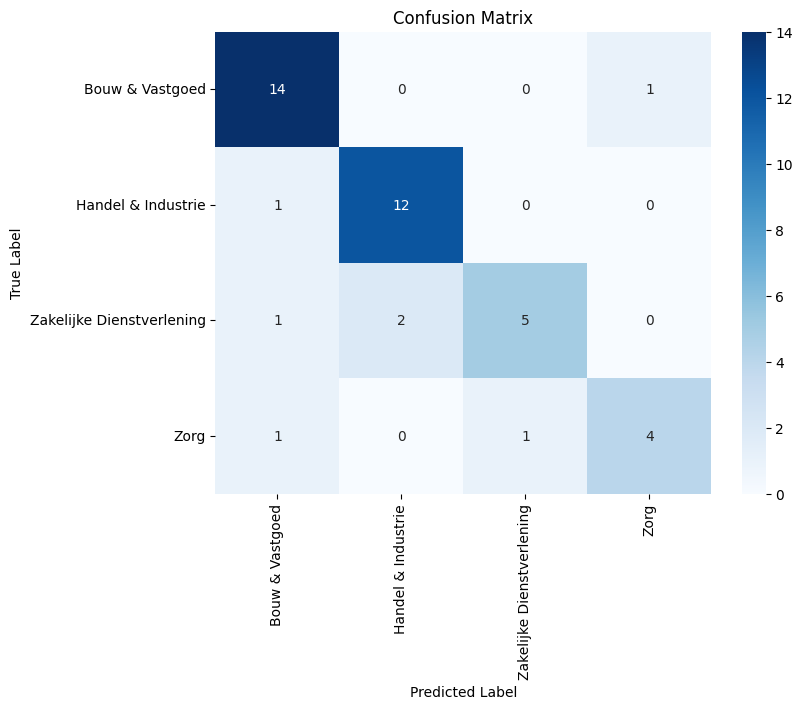

In [11]:
# NB model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="BERTje", 
                               model_type="naive_bayes",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating RobBERT embedding, this may take a few minutes.
Best svm Params for k=1: (10, 'rbf'), Mean Validation Accuracy: 0.8462
param_results: {(0.1, 'linear'): [0.75], (0.1, 'rbf'): [0.34615384615384615], (0.1, 'poly'): [0.36538461538461536], (1, 'linear'): [0.6923076923076923], (1, 'rbf'): [0.6923076923076923], (1, 'poly'): [0.6923076923076923], (10, 'linear'): [0.6923076923076923], (10, 'rbf'): [0.8461538461538461], (10, 'poly'): [0.7115384615384616]}
mean results: {(0.1, 'linear'): 0.75, (0.1, 'rbf'): 0.34615384615384615, (0.1, 'poly'): 0.36538461538461536, (1, 'linear'): 0.6923076923076923, (1, 'rbf'): 0.6923076923076923, (1, 'poly'): 0.6923076923076923, (10, 'linear'): 0.6923076923076923, (10, 'rbf'): 0.8461538461538461, (10, 'poly'): 0.7115384615384616}
best validation accuracy for K=1: 0.8461538461538461
best functionwide validation accuracy: 0

Best svm Params for k=2: (0.1, 'linear'), Mean Validation Accuracy: 0.7500
param_results: {(0.1, 'linear'): [0.6730769230769231, 0.82

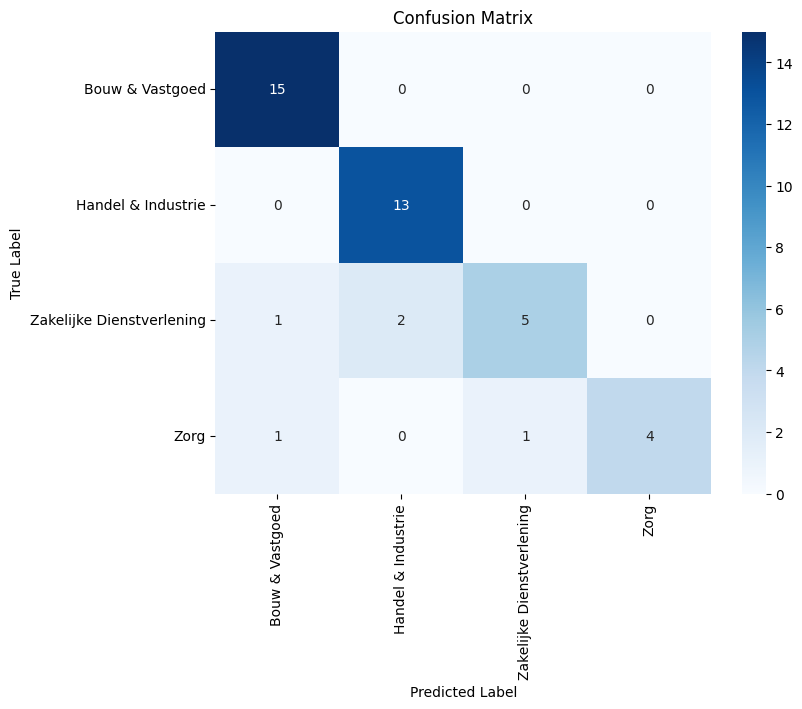

In [12]:
# SVM model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="RobBERT", 
                               model_type="svm",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.

Using N-gram POS Features (n=5)...
Best random_forest Params for k=1: 5, Mean Validation Accuracy: 0.7500
param_results: {5: [0.75], 10: [0.75], 15: [0.75], 20: [0.75], None: [0.75]}
mean results: {5: 0.75, 10: 0.75, 15: 0.75, 20: 0.75, None: 0.75}
best validation accuracy for K=1: 0.75
best functionwide validation accuracy: 0

Best random_forest Params for k=2: 5, Mean Validation Accuracy: 0.7404
param_results: {5: [0.7307692307692307, 0.75], 10: [0.75, 0.6923076923076923], 15: [0.7115384615384616, 0.6923076923076923], 20: [0.7115384615384616, 0.6923076923076923], None: [0.7115384615384616, 0.6923076923076923]}
mean results: {5: 0.7403846153846154, 10: 0.7211538461538461, 15: 0.7019230769230769, 20: 0.7019230769230769, None: 0.7019230769230769}
best validation accuracy for K=2: 0.7403846153846154
best functionwide validation accuracy: 0.75

Best random_forest Params for k=3: 5, Mean Validation Accuracy: 0.7756
param_results: {5

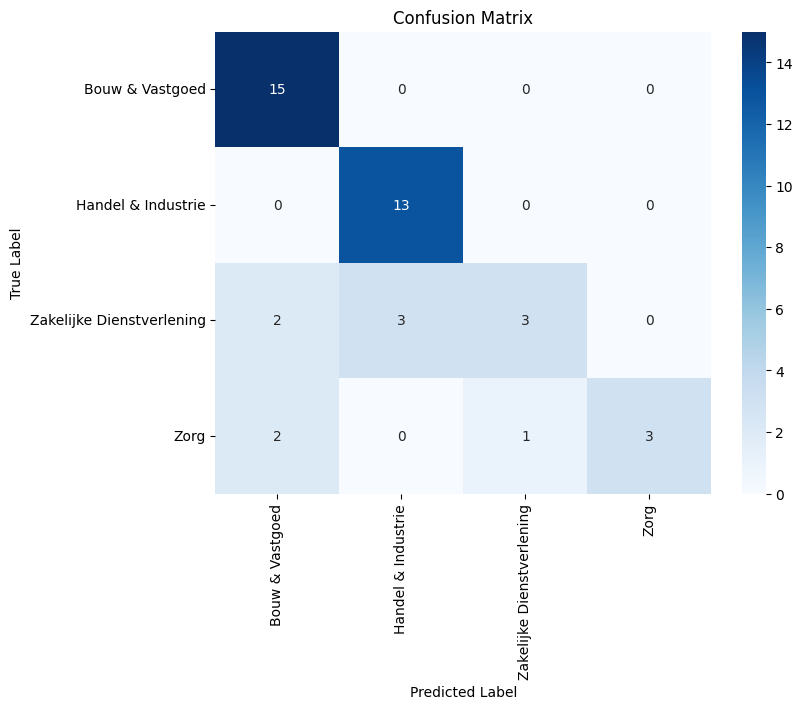

In [13]:
# RF model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="BERTje", 
                               model_type="random_forest",
                               pos="ngram", 
                               ngram_size=5,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]

# Test on unseen 2025 news articles

This section aims to test the obtained classifier for 32 unseen articles, 8 for each class. <br>
To achieve this, we first load the data

In [9]:
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

directory = '2025 test set'
df_experiment = pd.DataFrame(columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])

print('Please ensure that only pdf files of articles are present in the subfolders of the specified directory')
article_nr = 1
for folder in os.listdir(directory):
    folder_size = len(os.listdir(directory + "\\" + folder))
    print(f'{folder_size} article(s) detected in {folder} folder')
    
    for article in os.listdir(directory + '\\' + folder):
        text = extract_text_from_pdf(directory + '\\' + folder + '\\' + article)
        date = article.split(' ')[-1].split('.')[0] #Remove the article number and ".pdf" to obtain the publication date
        
        paragraphs = [para.strip() for para in text.split("\n \n") if para.strip()]
        para_nr = 1
        for para in paragraphs:
            df_temp = pd.DataFrame([[article_nr, para_nr, para, folder, date]], 
                                   columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])
            df_experiment = pd.concat([df_experiment, df_temp])
            para_nr += 1
        article_nr += 1
        
df_experiment.set_index(['article_id' , 'paragraph_id'], inplace=True)
df_experiment['publication_date'] = pd.to_datetime(df_experiment['publication_date'], format='%d-%m-%Y')
df_experiment["text"] = df_experiment["text"].str.replace(r'\n(?!\s)', '\n ', regex=True) #Ensures "\n" is followed by a space so it can be identified esier.

Please ensure that only pdf files of articles are present in the subfolders of the specified directory
9 article(s) detected in Bouw & Vastgoed folder
7 article(s) detected in Handel & Industrie folder
8 article(s) detected in Zakelijke Dienstverlening folder
8 article(s) detected in Zorg folder


In [10]:
df_experiment

text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Makelaars: huizenprijzen stijgen nog, maar nie...   
...                                                                    ...   
32         3             Wat betekent deze initiatiefwet voor huisartse...   
           4             Hoe staat dat model dan onder druk? \n ‘Op vee...   
           5             Zelfs in relatief geconsolideerde sectoren zoa...   
           6             Vindt u privaat geld in de zorg principieel on...   
           7             Een Kamermeerderheid wil private equity comple...   

                                   group publication_date  
article_id paragraph_id                                    
1          1             Bouw & Vastgoed       2024-12-23  
           2             Bouw & Vastgoed       2024-12-23  
           3             Bouw & Vastgoed       2024-12-23  
           4             Bouw & Vastgoed       2024-12-23  
2          1             Bouw & Vastgoed       2025-01-09  
...                                  ...              ...  
32         3                        Zorg       2025-02-27  
           4                        Zorg       2025-02-27  
           5                        Zorg       2025-02-27  
           6                        Zorg       2025-02-27  
           7                        Zorg       2025-02-27  

[122 rows x 3 columns]

In [11]:
# Load the 'nl_core_news_sm' model
nlp = spacy.load('nl_core_news_sm')

# Add [NEWLINE] as a single token so that it is not split into 3 seperate tokens
special_cases = {"[NEWLINE]": [{"ORTH": "[NEWLINE]"}]}
nlp.tokenizer.add_special_case("[NEWLINE]", [{"ORTH": "[NEWLINE]"}])

df_experiment_clean = df_experiment.copy()
df_experiment_clean['original_text'] = df_experiment_clean['text'].copy()
df_experiment_clean = df_experiment_clean[['original_text', 'text', 'group']]

In [12]:
df_experiment_clean

original_text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Makelaars: huizenprijzen stijgen nog, maar nie...   
...                                                                    ...   
32         3             Wat betekent deze initiatiefwet voor huisartse...   
           4             Hoe staat dat model dan onder druk? \n ‘Op vee...   
           5             Zelfs in relatief geconsolideerde sectoren zoa...   
           6             Vindt u privaat geld in de zorg principieel on...   
           7             Een Kamermeerderheid wil private equity comple...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Makelaars: huizenprijzen stijgen nog, maar nie...   
...                                                                    ...   
32         3             Wat betekent deze initiatiefwet voor huisartse...   
           4             Hoe staat dat model dan onder druk? \n ‘Op vee...   
           5             Zelfs in relatief geconsolideerde sectoren zoa...   
           6             Vindt u privaat geld in de zorg principieel on...   
           7             Een Kamermeerderheid wil private equity comple...   

                                   group  
article_id paragraph_id                   
1          1             Bouw & Vastgoed  
           2             Bouw & Vastgoed  
           3             Bouw & Vastgoed  
           4             Bouw & Vastgoed  
2          1             Bouw & Vastgoed  
...                                  ...  
32         3                        Zorg  
           4                        Zorg  
           5                        Zorg  
           6                        Zorg  
           7                        Zorg  

[122 rows x 3 columns]

In [13]:
def case_normalization(text):
    """Returns string of input containing only lowercase letters apart from [NEWLINE], which replaces \n"""
    text = text.lower()
    text = text.replace('\n', ' [NEWLINE] ')
    while text != text.replace('  ', ' '):
        text = text.replace('  ', ' ')
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(case_normalization)

In [14]:
def remove_punctuation(text):
    """Returns the input text with all punctuation removed"""
    
    text = text.translate(text.maketrans("", "", string.punctuation))
    text = text.replace("NEWLINE", "[NEWLINE]")
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_punctuation)

In [15]:
def remove_stopwords(text):
    """Returns string of input text with stopwords removed"""
    
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    text = " ".join(filtered_words)
    return text
    
    
# nlp = spacy.load("nl_core_news_sm")
df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_stopwords)

In [16]:
def lemmatization(df, text_column="text", output_column="text"):
    """Lemmatizes the text in a specified column of a DataFrame and adds the results to a new column."""
    
    # Ensure the input column exists in the DataFrame
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' does not exist in the DataFrame.")
        
    # Apply SpaCy processing and lemmatization
    df[output_column] = df[text_column].apply(
        lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_space]))
    
    return df

df_experiment_clean['text before lemmatization'] = df_experiment_clean['text'].copy()
df_experiment_clean = lemmatization(df_experiment_clean, text_column="text")

In [17]:
def POS_tagging(text):
    """Returns a list of (token, POS tag) tuples for the input text"""
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

df_experiment_clean['pos_tags'] = df_experiment_clean['text'].apply(POS_tagging)

In [18]:
df_experiment_clean

original_text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Makelaars: huizenprijzen stijgen nog, maar nie...   
...                                                                    ...   
32         3             Wat betekent deze initiatiefwet voor huisartse...   
           4             Hoe staat dat model dan onder druk? \n ‘Op vee...   
           5             Zelfs in relatief geconsolideerde sectoren zoa...   
           6             Vindt u privaat geld in de zorg principieel on...   
           7             Een Kamermeerderheid wil private equity comple...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             huis 12 duur november groot stijging ruim twee...   
           2             jarenlange daling huizenprijzen beginnen 2013 ...   
           3             november wisselden 17973 woning eigenaar 18 [N...   
           4             corrigeren inflatie huizenprijzen Nederland 20...   
2          1             makelaar huizenprijzen stijgen Amsterdam Eindh...   
...                                                                    ...   
32         3             betekenen initiatiefwet huisarts praktijk will...   
           4             staan model druk [NEWLINE] plekken samenleving...   
           5             relatief consolideren sector dierenartsen [NEW...   
           6             vinden privaat geld zorg principieel onwenseli...   
           7             kamermeerderheid privaat Equity compleet zorg ...   

                                   group  \
article_id paragraph_id                    
1          1             Bouw & Vastgoed   
           2             Bouw & Vastgoed   
           3             Bouw & Vastgoed   
           4             Bouw & Vastgoed   
2          1             Bouw & Vastgoed   
...                                  ...   
32         3                        Zorg   
           4                        Zorg   
           5                        Zorg   
           6                        Zorg   
           7                        Zorg   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             huizen 12 duurder november grootste stijging r...   
           2             jarenlange dalingen huizenprijzen begonnen 201...   
           3             november wisselden 17973 woningen eigenaar 18 ...   
           4             gecorrigeerd inflatie huizenprijzen nederland ...   
2          1             makelaars huizenprijzen stijgen amsterdam eind...   
...                                                                    ...   
32         3             betekent initiatiefwet huisartsen praktijk wil...   
           4             staat model druk [NEWLINE] ‘ plekken samenlevi...   
           5             relatief geconsolideerde sectoren dierenartsen...   
           6             vindt privaat geld zorg principieel onwenselij...   
           7             kamermeerderheid private equity compleet zorg ...   

                                                                  pos_tags  
article_id paragraph_id                                                     
1          1             [(huis, NOUN), (12, NUM), (duur, NOUN), (novem...  
           2             [(jarenlange, ADJ), (daling, NOUN), (huizenpri...  
           3             [(november, PROPN), (wisselden, VERB), (17973,...  
           4             [(corrigeren, ADJ), (inflatie, NO

Now we re-create the best model we found, but with all data from before 2025. We then test its performance on the 2025 articles

Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total test accuracy: 0.7704918032786885

Class '0' Accuracy: 0.8684
Class '1' Accuracy: 0.8333
Class '2' Accuracy: 0.6579
Class '3' Accuracy: 0.7500


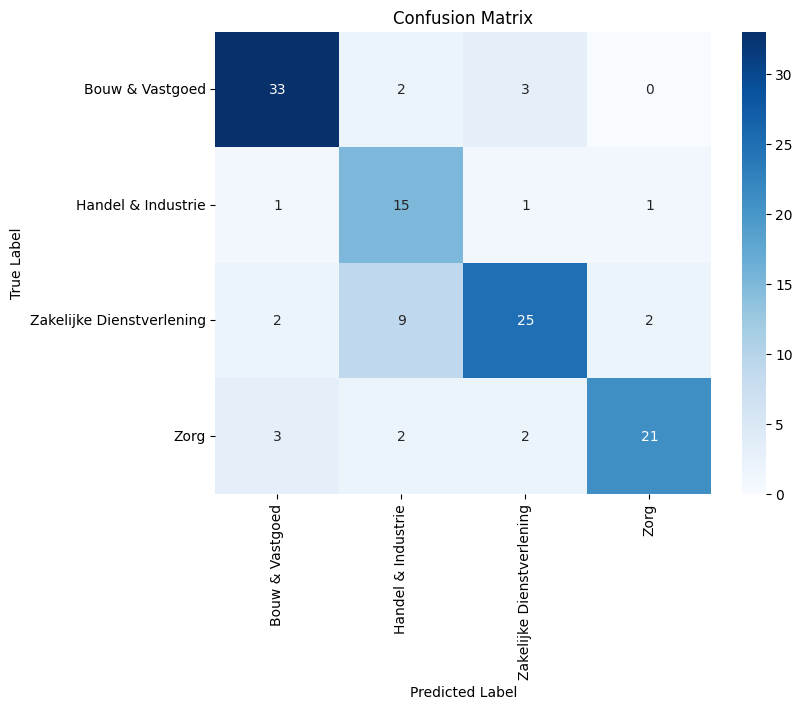

In [19]:
#Below we have the 3 parameter settings that were found to be optimal
model_name = "pdelobelle/robbert-v2-dutch-base" #We use RobBERT
C = 10
kernel = "rbf"

df["label"] = df["group"].astype("category").cat.codes 
df_experiment_clean["label"] = df_experiment_clean["group"].astype("category").cat.codes 

#We load RobBERT and get the word embeddings of the training and test sets
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_word_embedding(text):
    with torch.no_grad():
        tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        output = model(**tokens)
        embeddings = output.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().numpy()

#Defines training and testing data
X_train = np.array([get_word_embedding(text) for text in df["text"]])
X_test = np.array([get_word_embedding(text) for text in df_experiment_clean["text"]])
y_train = df["label"].values
y_test = df_experiment_clean["label"].values

#Trains classifiers and runs it on the test set
classifier = SVC(kernel=kernel, C=C, probability=True)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)
paragraph_accuracy = accuracy_score(y_test, y_pred)

# Calculate per-class accuracy: TP / (TP + FN)
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y_test)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print(f"Total test accuracy: {paragraph_accuracy}\n")
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

#Visualize the resulting confusion matrix of the test set
class_mapping = {0: 'Bouw & Vastgoed', 1: 'Handel & Industrie', 2: 'Zakelijke Dienstverlening', 3: 'Zorg'}
class_names = [class_mapping[i] for i in np.unique(y_test)]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

These results seem quite nice. However, they are on a paragraph level. We would like predictions per article, not per paragraph. <br>
We use 2 methods: <br>
> - Majority Voting:
> > - Predict the class that is predicted most frequently across its paragraphs
> - Summing Probabilities:
> > - Sum the probabilities for each class across all paragraphs in the article.
> > - Normalize the summed probabilities and select the class with the highest probability.

Method 1 (Summing Probabilities) Accuracy: 0.8125
Method 2 (Majority Voting) Accuracy: 0.8750


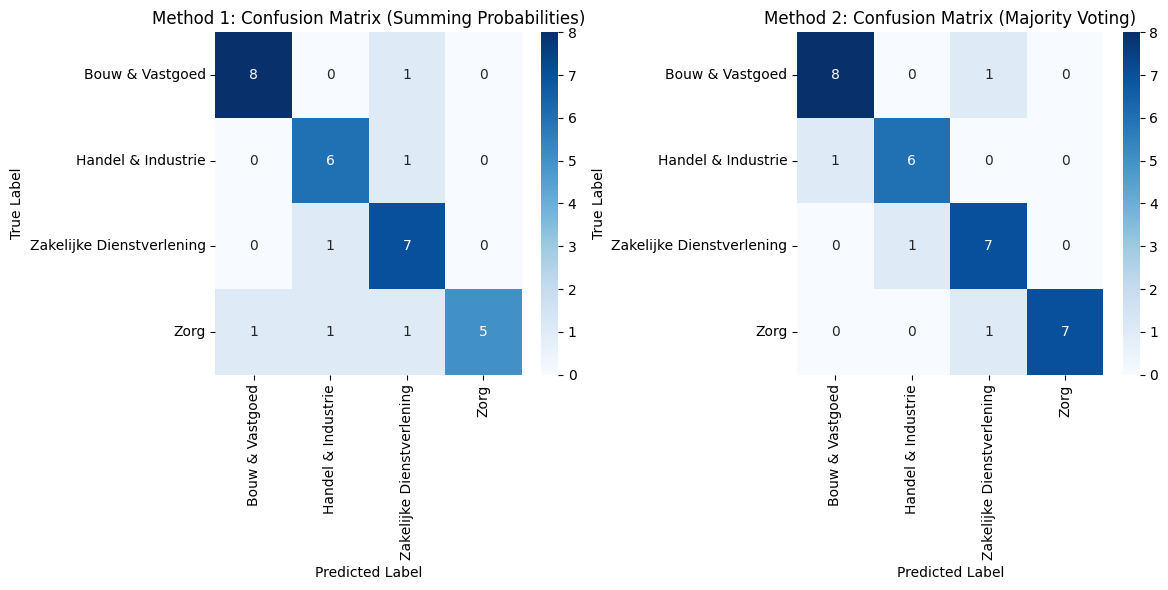

In [21]:
df_experiment_clean['pred_probabilities'] = list(y_pred_proba)

# ---- Method 1: Summing Probabilities ----
def method_1_summing_probabilities(df):
    # For each article, sum the probabilities for each class across all paragraphs
    article_preds_prob = df.groupby('article_id')['pred_probabilities'].apply(lambda x: np.sum(np.array(x), axis=0))
    
    # Normalize the summed probabilities and select the class with the highest probability
    article_preds = article_preds_prob.apply(lambda x: np.argmax(x / np.sum(x)))
    return article_preds

# ---- Method 2: Majority Voting ----
def method_2_majority_voting(df):
    # For each paragraph, select the class with the highest probability
    df['pred_class'] = df['pred_probabilities'].apply(lambda x: np.argmax(x))
    
    # Now, for each article, apply majority voting
    article_preds_majority = df.groupby('article_id')['pred_class'].apply(lambda x: Counter(x).most_common(1)[0][0])
    return article_preds_majority


# Apply Method 1 (Summing Probabilities)
article_preds_method_1 = method_1_summing_probabilities(df_experiment_clean)

# Apply Method 2 (Majority Voting)
article_preds_method_2 = method_2_majority_voting(df_experiment_clean)

# ---- Evaluation ----
# Get true labels for articles (assumes all paragraphs in an article share the same true label)
y_true_articles = df_experiment_clean.groupby('article_id')['label'].first()

# Evaluate Method 1
article_accuracy_method_1 = accuracy_score(y_true_articles, article_preds_method_1)
print(f"Method 1 (Summing Probabilities) Accuracy: {article_accuracy_method_1:.4f}")

# Evaluate Method 2
article_accuracy_method_2 = accuracy_score(y_true_articles, article_preds_method_2)
print(f"Method 2 (Majority Voting) Accuracy: {article_accuracy_method_2:.4f}")

# ---- Confusion Matrices ----
cm_method_1 = confusion_matrix(y_true_articles, article_preds_method_1)
cm_method_2 = confusion_matrix(y_true_articles, article_preds_method_2)

# Visualize confusion matrices
class_names = [class_mapping[i] for i in np.unique(y_test)]
plt.figure(figsize=(12, 6))

# Method 1: Summing Probabilities Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_method_1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Method 1: Confusion Matrix (Summing Probabilities)')

# Method 2: Majority Voting Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_method_2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Method 2: Confusion Matrix (Majority Voting)')

plt.tight_layout()
plt.show()

We use the following method: <br>
> - Default to Majority Voting
> - If there is a tie in the majority voting, we fall back to Summing Probabilities
> - We predict the unknown class if:
> > - The difference between the two highest summed, normalized probabilities is smaller than a pre-defined threshold X
> > - The highest summed, normalized probability is below a pre-defined threshold Y

Accuracy with unknown class as incorrect: 0.8125
Accuracy excluding unknown class predictions: 0.8966
Percentage of articles classified as 'unknown': 9.38%


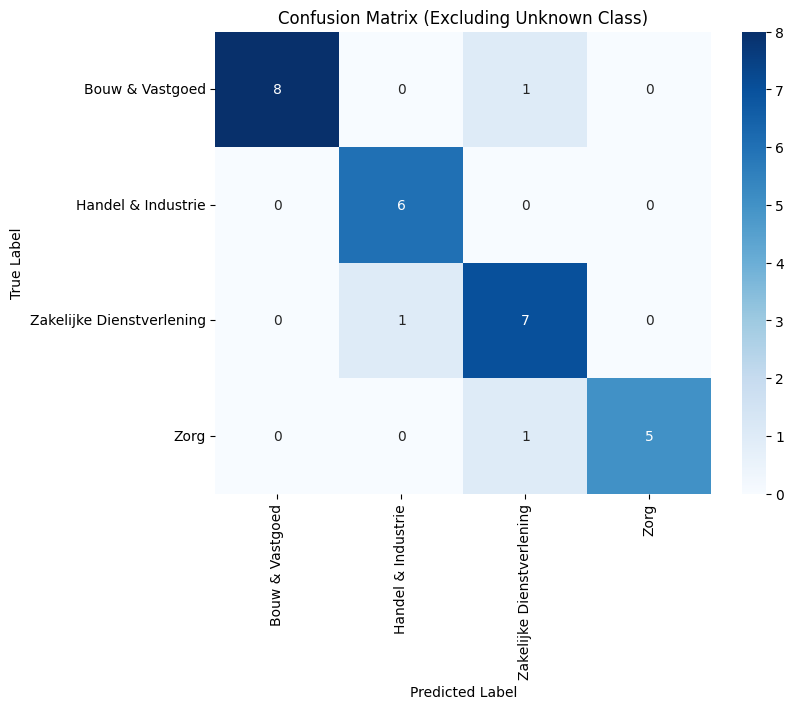

In [45]:
X = 0.1
Y = 0.3
UNKNOWN_CLASS = -1

def combined_method(df, X, Y):
    """This function combines majority voting and summed probability normalization to predict the most likely class 
    for each article based on its paragraphs. The method works as follows:

    1. **Majority Voting**: For each paragraph, the class with the highest predicted probability is selected.
    2. **Tie-breaking with Summed Probabilities**: If there is a tie in the majority voting (i.e., multiple classes have equal counts), 
       the summed probabilities for each class across all paragraphs of an article are calculated and normalized. 
       The class with the highest summed probability is then selected.
    3. **Handling Uncertainty ("Unknown" Class)**: If the difference between the two highest summed probabilities is below a 
       specified threshold (X) or if the highest probability is below a minimum threshold (Y), the article is classified as "unknown".

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing the predicted class probabilities for each paragraph in an article, indexed by article_id and paragraph_id.
    X : float
        The threshold below which the difference between the two highest summed probabilities is considered too small to resolve a tie.
    Y : float
        The minimum summed probability for the highest class. If the highest probability is below this threshold, the article is classified as "unknown".

    Returns:
    --------
    article_preds_final : dict
        A dictionary mapping each article_id to its predicted class label, including "unknown" class predictions when applicable.
    """
    
    df_reset = df.reset_index()

    # Step 1: Perform majority voting (predict most likely class for each paragraph)
    df_reset['pred_class'] = df_reset['pred_probabilities'].apply(lambda x: np.argmax(x))  # Most likely class per paragraph

    # Group by article_id and get top 2 predicted classes from majority voting
    article_preds_majority = df_reset.groupby('article_id')['pred_class'].apply(lambda x: Counter(x).most_common(2))

    # Step 2: Apply tie-breaking and fallback to summing probabilities
    article_preds_final = {}
    for article_id, top_preds in article_preds_majority.items():
        if len(top_preds) > 1:  # There's a tie
            # Get the top 2 predicted classes and their counts from majority voting
            class_1, count_1 = top_preds[0]
            class_2, count_2 = top_preds[1]
            
            # Get summed probabilities for both classes (sum across all paragraphs for each class)
            summed_probs = df_reset[df_reset['article_id'] == article_id].groupby('pred_class')['pred_probabilities'].apply(
                lambda x: np.sum(np.array(x), axis=0)
            )

            # Now, instead of summing across axis 1, we directly get the total sum of all probabilities across the article
            total_sum = np.sum([np.sum(probabilities) for probabilities in summed_probs])
            
            # Normalize the summed probabilities so that they sum to 1 across all classes
            summed_probs_normalized = summed_probs.apply(lambda x: x / total_sum)


            prob_1 = summed_probs_normalized.loc[class_1].sum()
            prob_2 = summed_probs_normalized.loc[class_2].sum()

            # For more informative print statements, uncomment the lines below
            # if abs(prob_1 - prob_2) < X and prob_1 < Y:
            #     print(f"Both probabilities are close: {prob_1}, {prob_2}")
            # elif abs(prob_1 - prob_2) < X:
            #     print(f"Difference between probabilities too small: {prob_1}, {prob_2}")
            # elif prob_1 < Y:
            #     print(f"Probabilities too low: {prob_1}")
            # else:
            #     print(f"Neither condition met")

            # Apply the threshold rules to decide if the article should be classified as unknown
            if abs(prob_1 - prob_2) < X or prob_1 < Y:
                article_preds_final[article_id] = UNKNOWN_CLASS
            else:
                # If there's no tie or the difference is significant, use the class with the higher probability
                article_preds_final[article_id] = class_1 if prob_1 > prob_2 else class_2
        else:
            # No tie, just use majority voting
            article_preds_final[article_id] = top_preds[0][0]

    return article_preds_final

# Get the final predictions using the combined method
article_preds_combined = combined_method(df_experiment_clean, X, Y)

# ---- Evaluation ----
# Get true labels for articles (assumes all paragraphs in an article share the same true label)
y_true_articles = df_experiment_clean.groupby('article_id')['label'].first()

# 1. Accuracy with the unknown class treated as incorrect:
# Convert the predictions dictionary to a list of predictions, ordered by article_id
article_preds_combined_list = [article_preds_combined[article_id] for article_id in y_true_articles.index]
article_accuracy_with_unknown_incorrect = accuracy_score(y_true_articles, article_preds_combined_list)
print(f"Accuracy with unknown class as incorrect: {article_accuracy_with_unknown_incorrect:.4f}")

# 2. Accuracy excluding articles with the unknown class predicted:
# Exclude articles where the unknown class was predicted
valid_articles = [article_id for article_id, pred in article_preds_combined.items() if pred != UNKNOWN_CLASS]
y_true_valid = y_true_articles.loc[valid_articles]
y_pred_valid = [article_preds_combined[article_id] for article_id in valid_articles]

# Accuracy on valid articles (excluding unknown class)
article_accuracy_without_unknown = accuracy_score(y_true_valid, y_pred_valid)
print(f"Accuracy excluding unknown class predictions: {article_accuracy_without_unknown:.4f}")

# 3. Percentage of articles classified as "unknown":
unknown_count = sum(1 for pred in article_preds_combined.values() if pred == UNKNOWN_CLASS)
total_articles = len(article_preds_combined)  # Ensure we are using the total number of articles
unknown_percentage = (unknown_count / total_articles) * 100
print(f"Percentage of articles classified as 'unknown': {unknown_percentage:.2f}%")

# ---- Confusion Matrix (excluding unknown class predictions) ----
valid_article_preds_combined = [pred for pred in article_preds_combined.values() if pred != UNKNOWN_CLASS]
valid_y_true_articles = [y_true_articles[article_id] for article_id, pred in article_preds_combined.items() if pred != UNKNOWN_CLASS]

cm_combined_valid = confusion_matrix(valid_y_true_articles, valid_article_preds_combined)

# Visualize the confusion matrix excluding unknown class predictions
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined_valid, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Excluding Unknown Class)')
plt.show()

# Feature Importance

Since we use a Support Vector Machine with a non linear kernel, we cannot simply use the built-in sklearn functions to obtain feature importance. <br>
Additionally, Shapley (Shapley Additive exPlanations) does not work in this case because the SVM model receives only aggregated embeddings as input, not individual tokens, so it has no knowledge of which specific tokens contributed to its predictions. <br>
Instead, we use LIME (Local Interpretable Model-agnostic Explanations). LIME explains a model’s prediction by locally approximating it with a simple, interpretable model around a specific input, showing which parts of that input most influence the outcome.

In [21]:
class_names = list(class_mapping.values())  # ['Bouw & Vastgoed', ...]
explainer = LimeTextExplainer(class_names=class_names)

# Function for LIME: takes raw texts, returns prediction probabilities
def predict_proba(texts):
    embeddings = []
    for text in texts:
        emb = get_word_embedding(text)
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return classifier.predict_proba(embeddings)

First, we run LIME on a single row of the test set:

In [26]:
text_instance = df_experiment_clean.iloc[0]["text"]
explanation = explainer.explain_instance(text_instance, predict_proba, num_features=10, labels=[0], num_samples=500)

# Show in notebook
explanation.show_in_notebook(text=True)

# Or save as HTML
explanation.save_to_file('lime_explanation.html')

Now we aggregate the results per sector:

Bouw & Vastgoed:

In [40]:
top_n = 20
manual_label_index = 0  # Index of "Bouw & Vastgoed"
neighborhood_size = 1000 # Size of the neighborhood to learn a linear LIME model


explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(5):
for i in range(len(df_experiment_clean)):
    if (i)%10 == 0:
        print(f"Process: {i}/{len(df_experiment_clean)-1}")
        
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[manual_label_index], num_samples=neighborhood_size
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=manual_label_index)
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

print(f"Progress: Done")

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

Process: 0/121
Process: 10/121
Process: 20/121
Process: 30/121
Process: 40/121



KeyboardInterrupt



Handel & Industrie:

In [ ]:
top_n = 20
manual_label_index = 1  # Index of "Handel & Industrie"
neighborhood_size = 1000 # Size of the neighborhood to learn a linear LIME model


explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(5):
for i in range(len(df_experiment_clean)):
    if (i)%10 == 0:
        print(f"Process: {i}/{len(df_experiment_clean)-1}")
        
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[manual_label_index], num_samples=neighborhood_size
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=manual_label_index)
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

print(f"Progress: Done")

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

Zakelijke Dienstverlening:

In [ ]:
top_n = 20
manual_label_index = 2  # Index of "Zakelijke Dienstverlening"
neighborhood_size = 1000 # Size of the neighborhood to learn a linear LIME model


explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(5):
for i in range(len(df_experiment_clean)):
    if (i)%10 == 0:
        print(f"Process: {i}/{len(df_experiment_clean)-1}")
        
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[manual_label_index], num_samples=neighborhood_size
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=manual_label_index)
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

print(f"Progress: Done")

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

Zorg:

In [ ]:
top_n = 20
manual_label_index = 3  # Index of "Zorg"
neighborhood_size = 1000 # Size of the neighborhood to learn a linear LIME model


explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(5):
for i in range(len(df_experiment_clean)):
    if (i)%10 == 0:
        print(f"Process: {i}/{len(df_experiment_clean)-1}")
        
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[manual_label_index], num_samples=neighborhood_size
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=manual_label_index)
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

print(f"Progress: Done")

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

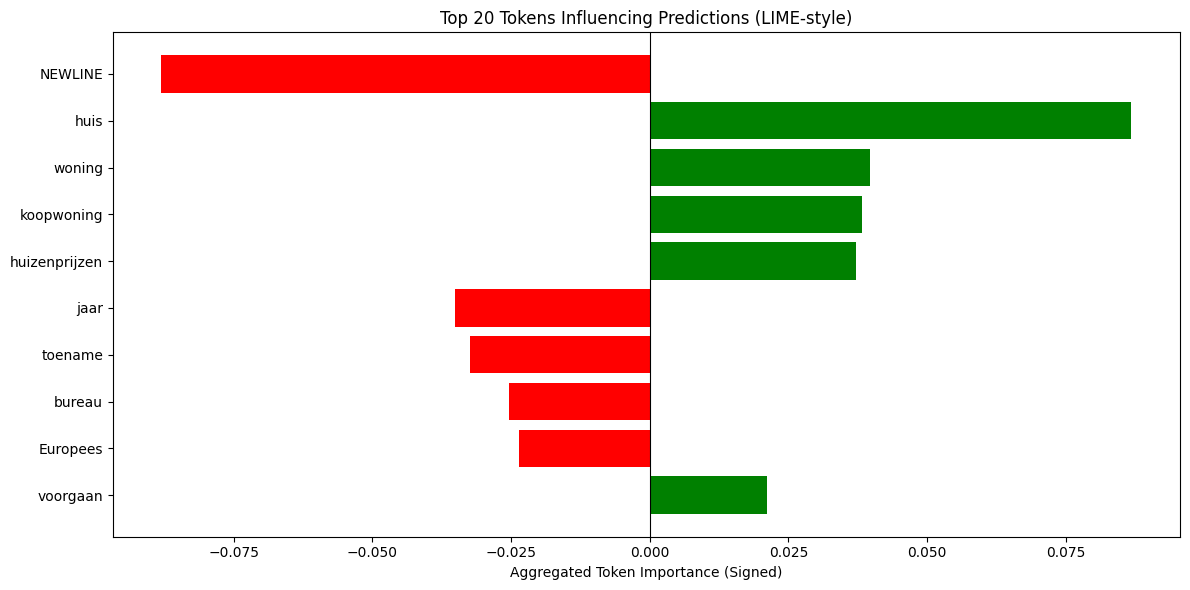

In [32]:
from lime.lime_text import LimeTextExplainer
from collections import defaultdict
import matplotlib.pyplot as plt

top_n = 20

explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(len(df_experiment_clean)):
for i in range(1):
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[y_test[i]], num_samples=500
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=y_test[i])
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

In [ ]:
from lime.lime_text import LimeTextExplainer
from collections import defaultdict
import matplotlib.pyplot as plt

top_n = 20

explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(len(df_experiment_clean)):
for i in range(len(df_experiment_clean)):
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=top_n, labels=[y_test[i]], num_samples=500
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=y_test[i])
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += score  # Absolute value to ignore polarity

top_tokens = sorted(token_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
tokens, scores = zip(*top_tokens)

# Choose colors: green for positive influence, red for negative
colors = ['green' if s > 0 else 'red' for s in scores]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color=colors[::-1])  # reverse for highest on top
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Aggregated Token Importance (Signed)')
plt.title(f'Top {top_n} Tokens Influencing Predictions (LIME-style)')
plt.tight_layout()
plt.show()

Top 20 tokens by total importance across dataset:
NEWLINE: 0.1790
huis: 0.0895
woning: 0.0692
jarenlange: 0.0477
voorgaan: 0.0361
2022: 0.0322
toename: 0.0305
Duitsland: 0.0304
hoog: 0.0285
koopwoning: 0.0270
duur: 0.0228
twee: 0.0218
piekmoment: 0.0213
centraal: 0.0212
piek: 0.0188
bereiken: 0.0170
maand: 0.0158
182634: 0.0145
huizenprijzen: 0.0134
2013: 0.0112


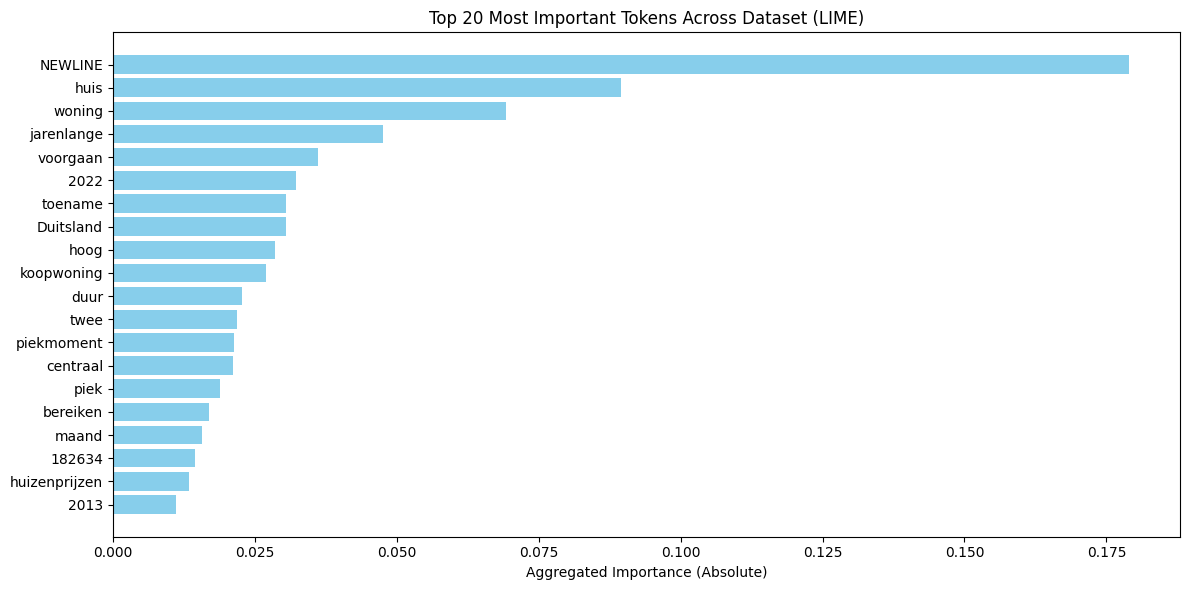

In [30]:
from lime.lime_text import LimeTextExplainer
from collections import defaultdict
import matplotlib.pyplot as plt


explainer = LimeTextExplainer(class_names=list(class_mapping.values()))
token_importance = defaultdict(float)

# for i in range(len(df_experiment_clean)):
for i in range(3):
    text_instance = df_experiment_clean.iloc[i]["text"]
    
    # Get explanation
    explanation = explainer.explain_instance(
        text_instance, predict_proba, num_features=10, labels=[y_test[i]], num_samples=500
    )
    
    # Explanation is label-specific, use the correct label
    exp_list = explanation.as_list(label=y_test[i])
    
    # Aggregate scores
    for token, score in exp_list:
        token_importance[token] += abs(score)  # Absolute value to ignore polarity

print("Top 20 tokens by total importance across dataset:")
top_tokens = sorted(token_importance.items(), key=lambda x: x[1], reverse=True)[:20]
for token, score in top_tokens:
    print(f"{token}: {score:.4f}")

# Plotting top 20
tokens, scores = zip(*top_tokens)
plt.figure(figsize=(12, 6))
plt.barh(tokens[::-1], scores[::-1], color="skyblue")
plt.xlabel("Aggregated Importance (Absolute)")
plt.title("Top 20 Most Important Tokens Across Dataset (LIME)")
plt.tight_layout()
plt.show()